## OCNT-DMSLIB-1 DMS Assay Run #9: TYK2 IL-23 Mini-DMS with Itacitinib

This is a mini-DMS dataset derived from the IL-23 reporter system covering chunk 16 only. There are 12 samples (3 replicates in each of 4 conditions), with the following structure:

| ID | Condition | Dosage | Replicates
| --- | ----------- | --- | ----------- |
| 1 | None | 0 | 3 |
| 2 | IL-23 | 1 | 3 |
| 3 | IL-23 | 10 | 3 |
| 4 | IL-23 + Itacitinib | 10 | 3 |

Let's check some effects we expect to observe (mainly QC parameters and stop codons), then examine the global distribution of mutant vs WT effects across conditions.

1. [Barcode Sequencing Distributions](#part1)
2. [Inference and Stop Codon Effects](#part2)
3. [Visualizations](#part3)
4. [Raw Data Review](#part4)

In [141]:
library(magrittr)
library(data.table)
library(ggrepel)
library(ggpubr)
library(vroom)
library(scales)
library(scico)
library(ggridges)
library(knitr)
library(ggbeeswarm)
library(fs)
library(patchwork)
library(ggnewscale)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version", "dispersion"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2)) %>%
        select(pos, clone, chunk, aa, estimate, std.error, dispersion, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

plot_coverage <- function(bcs, sample_id, destdir = datadir) {
    
    wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")
    
    bcs_subset <- bcs %>%
        filter(sample == sample_id)
    
    allpos <- expand_grid("pos" = unique(bcs$pos),
                     "mut_aa" = unique(bcs$mut_aa)) %>%
        filter(!paste0(pos, mut_aa) %in% paste0(wt_aa$pos, wt_aa$wt_aa))

    bcs_subset_expanded <- allpos %>%
        left_join(bcs_subset) %>%
        mutate(n = ifelse(is.na(n), 0, n))
    
    the_plot <- ggplot(bcs_subset_expanded) +
        geom_line(aes(x = as.numeric(pos), y = log10(n))) +
        theme_bw(base_size = 16) +
        ggtitle(paste0("Sample ", sample_id)) +
        facet_wrap(~mut_aa, ncol = 1) +
        xlab("TYK2 position") + ylab("log10(number of unique barcodes)")
    
    ggsave(str_c("coverage-plots/", gsub(".*/OCNT", "OCNT", destdir), "-sample", sample_id, ".pdf"),
           the_plot, width = 10, height = 20)
    
    return(the_plot)
}

make_profile <- function(poss, df){
    
    p1 <- df %>%
        filter(pos == poss) %>%
        ggplot() +
            geom_pointrange(aes(x = aa, y = estimate, color = condition,
                                ymin = estimate - 2*std.error,
                                ymax = estimate + 2*std.error),
                            position = position_dodge(width = 0.4)) +
            theme_pubr(base_size = 16) +
            geom_hline(yintercept = 0) + ggtitle(poss) +
            scale_color_manual(values = c("red", "black"))

    return(p1)
}

### Barcode Sequencing Distributions <a name="part1"></a>

In [7]:
mapped_counts <- vroom(str_c("../", datadir, "/tyk2-form.mapped-counts.tsv"),
                          col_names = c("sample", "barcode",  "count", "lib", "chunk", 
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon", "chunkGrp",
                                        "dox", "condition", "condition_conc","clone"))  %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT"))

bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

Rows: 664809 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, chunkGrp...
dbl  (5): count, chunk, pos, dox, condition_conc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


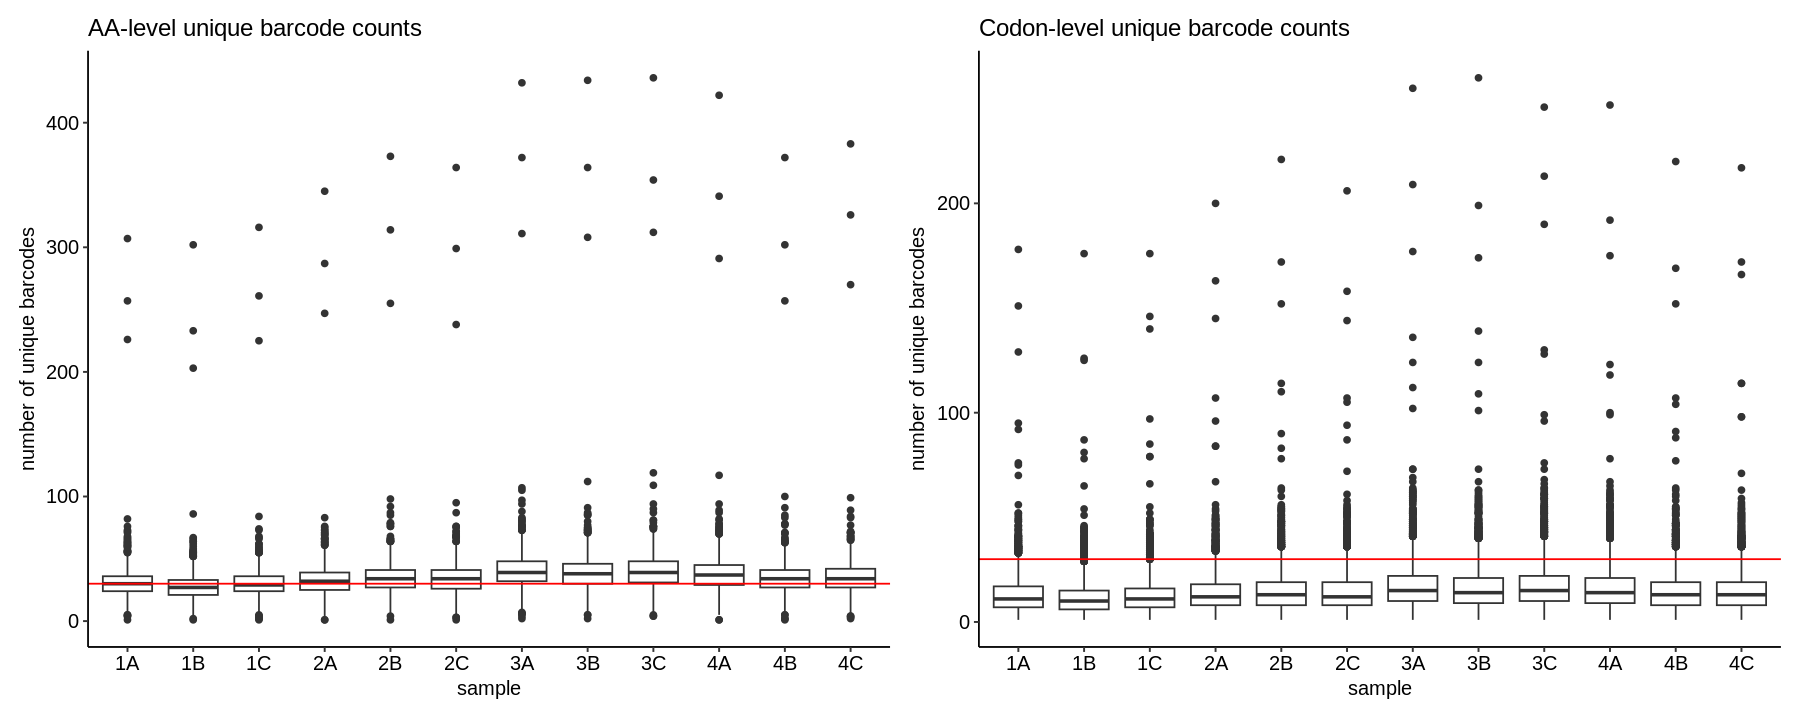

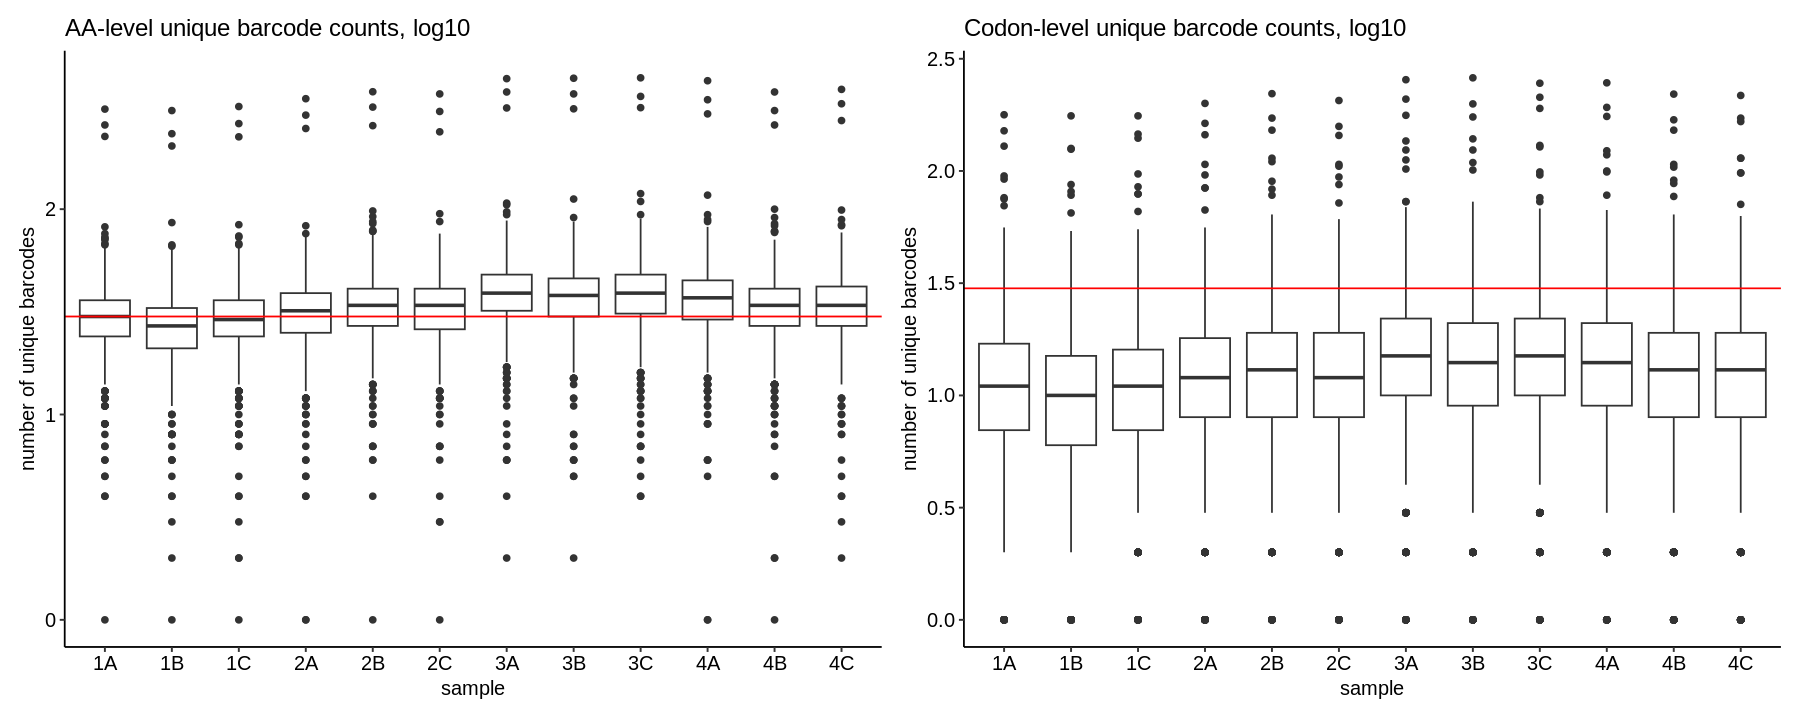

In [8]:
options(repr.plot.width = 15, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

To get a sense of positional distribution, we can show the same data as lineplots across the length of TYK2. Below is an example using the first sample; the remaining plots can be found [here](./coverage-plots):

In [9]:
coverage_plots <- map(.x = unique(bc_counts_aa$sample),
                      .f = ~plot_coverage(bc_counts_aa, ., destdir = datadir))

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(pos, mut_aa)`
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(pos, mut_aa)`
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with

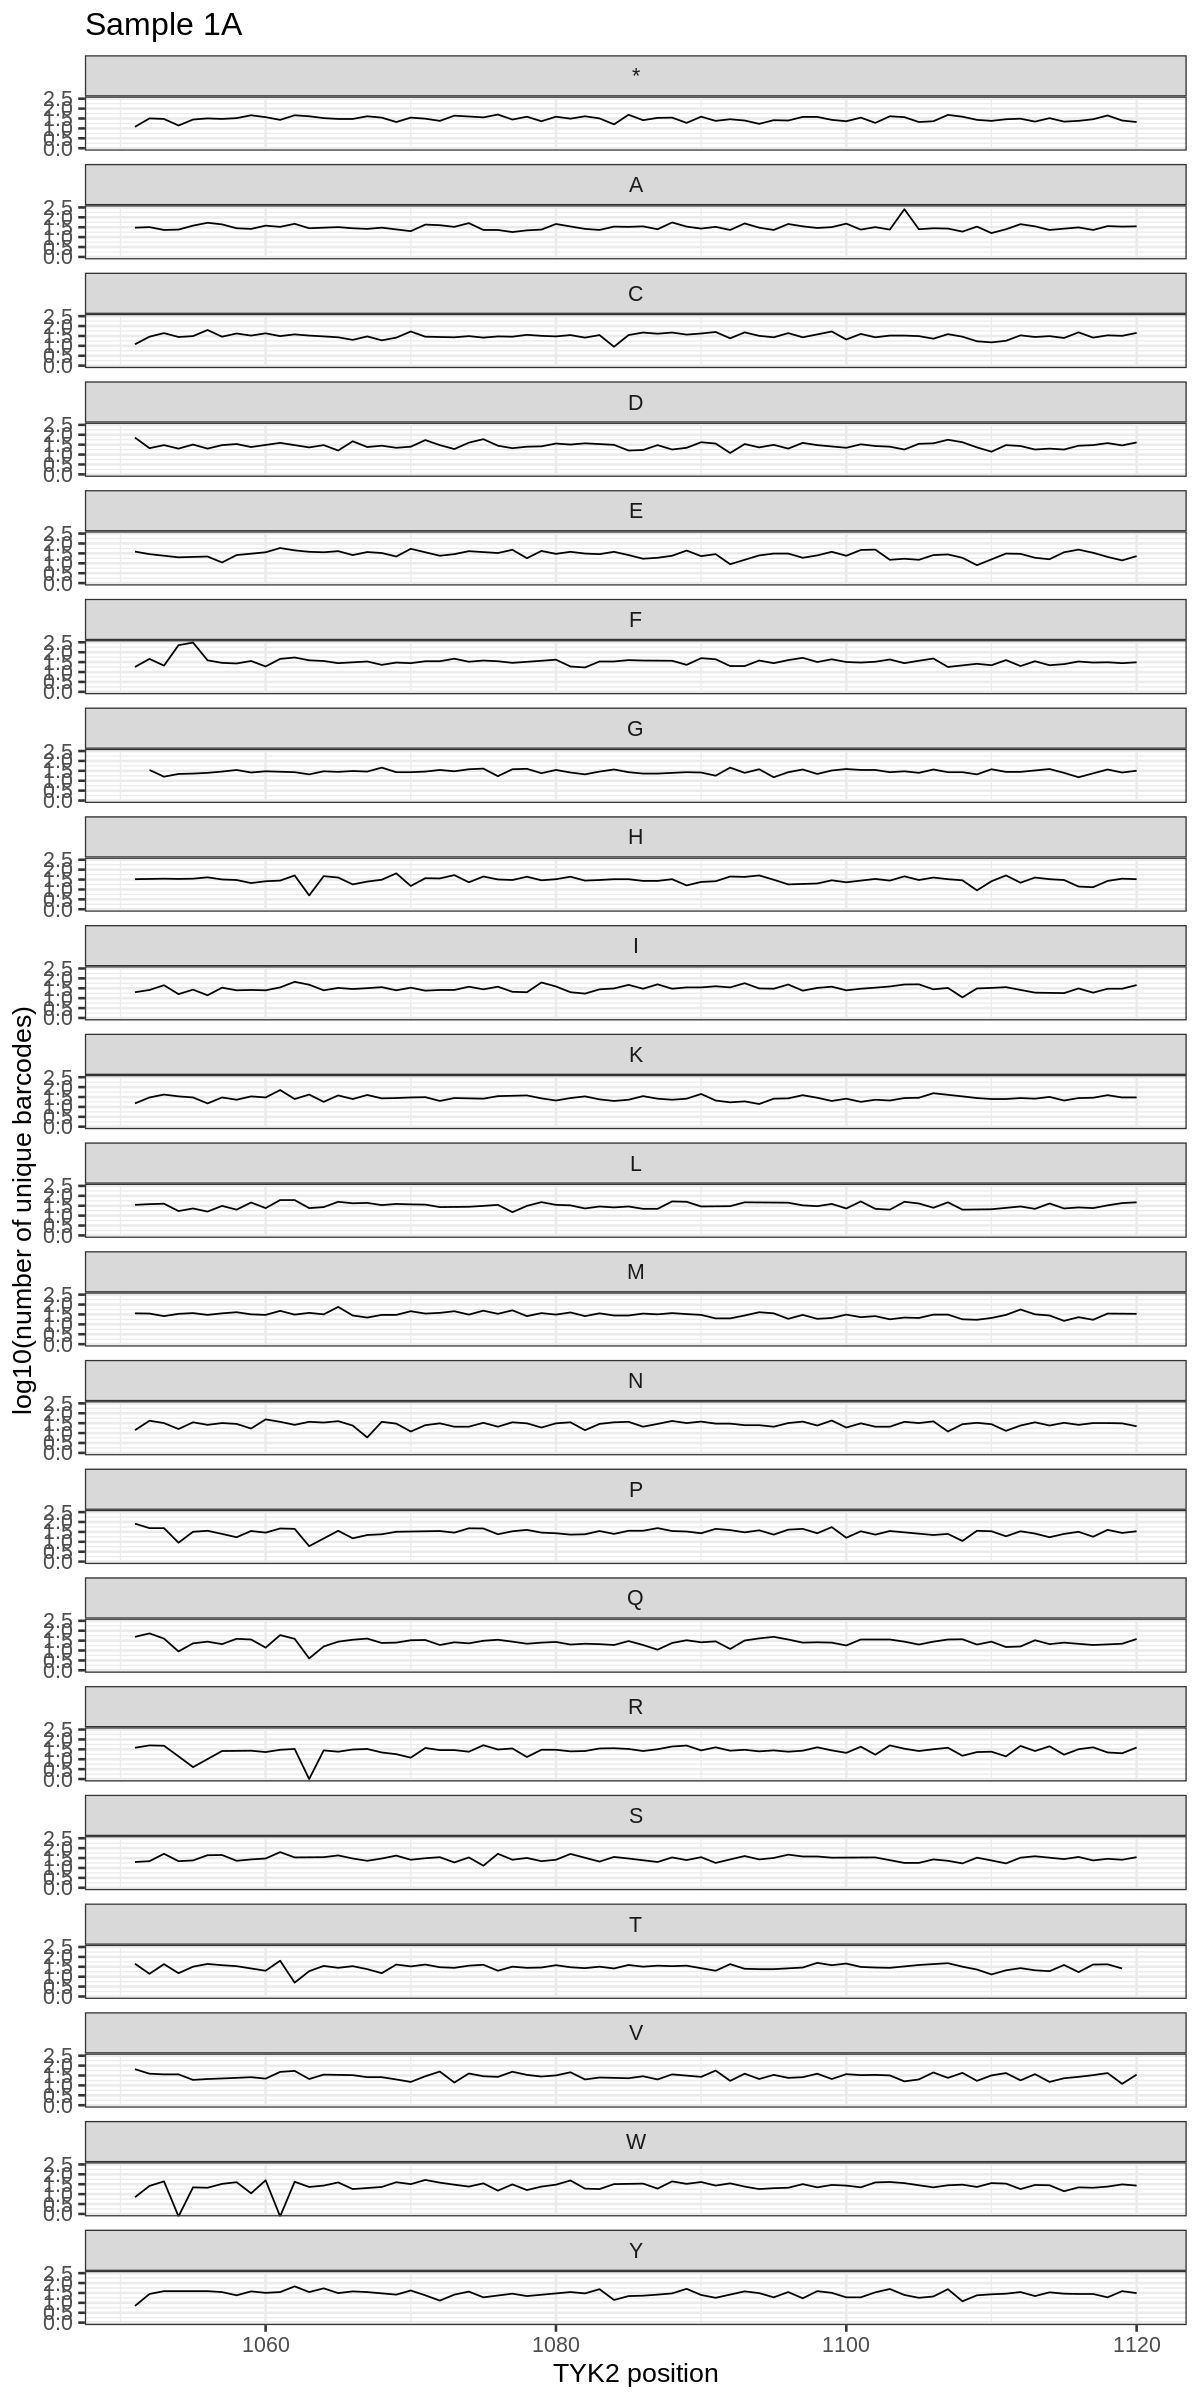

In [10]:
options(repr.plot.width = 10, repr.plot.height = 20)
coverage_plots[[1]]

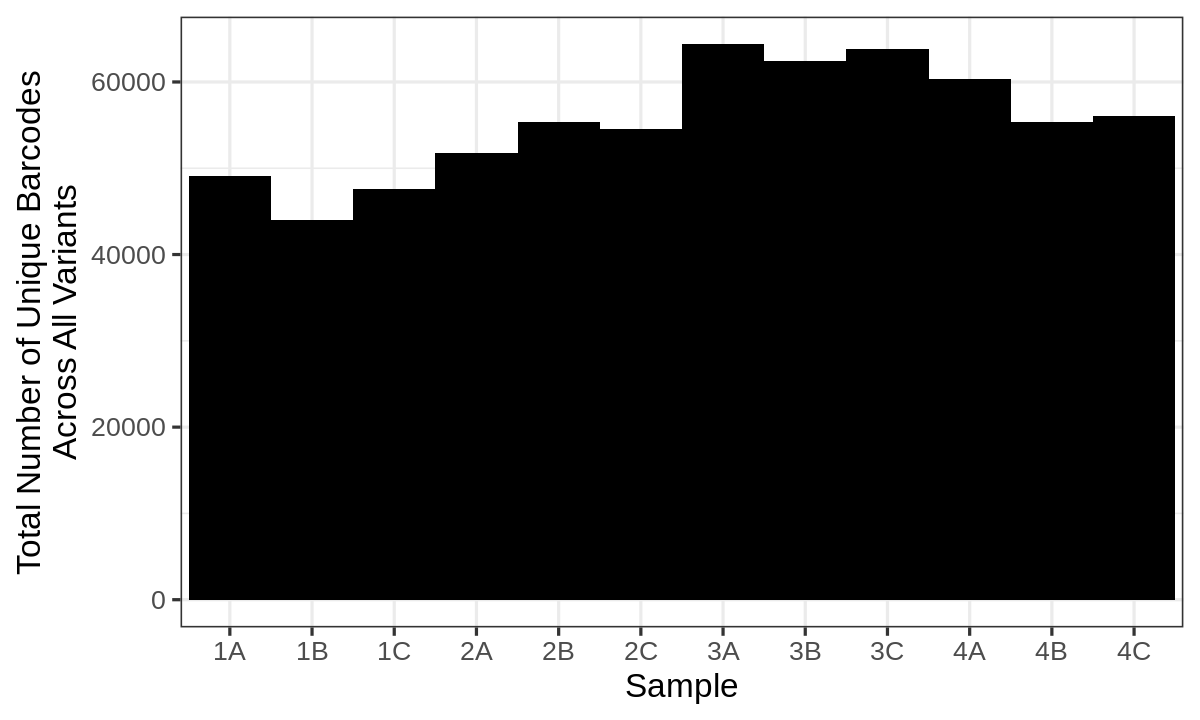

In [14]:
options(repr.plot.width = 10, repr.plot.height = 6)
mapped_counts %>%
    ungroup() %>%
    count(sample) %>%
    ggplot() +
        geom_bar(aes(x = sample, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw(base_size = 20) +
        xlab("Sample") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

### Inference and Stop Codon Effects <a name="part2"></a>

In [135]:
conditions <- tibble("condition" = c('IL23+Itacitinib10','IL231','IL2310','None0'),
                     "name" = c("IL-23 10 ng/mL + Itacitinib",
                                "IL-23 1 ng/mL",
                                "IL-23 10 ng/mL",
                                "None"))

In [136]:
sumstats <- read_tsv("../sumstats/TYK2/run9/tyk2_16-combined.sumstats.tsv",
                     col_types = c("ncccnnnnnc")) %>%
    filter(grepl("aa",term), pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2),
           condition = gsub("condition", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa)) %>%
    left_join(conditions)

wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")

Joining with `by = join_by(condition)`
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [137]:
sumstats %>%
    mutate(p.adj = p.adjust(p.value, method = "BH")) %>%
    select(-group) %>%
    write_tsv("../sumstats/TYK2/run9/tyk2-assay9-unnormalized.tsv")

aa_uniq <- unique(sumstats$aa)
pos_uniq <- 1:1187

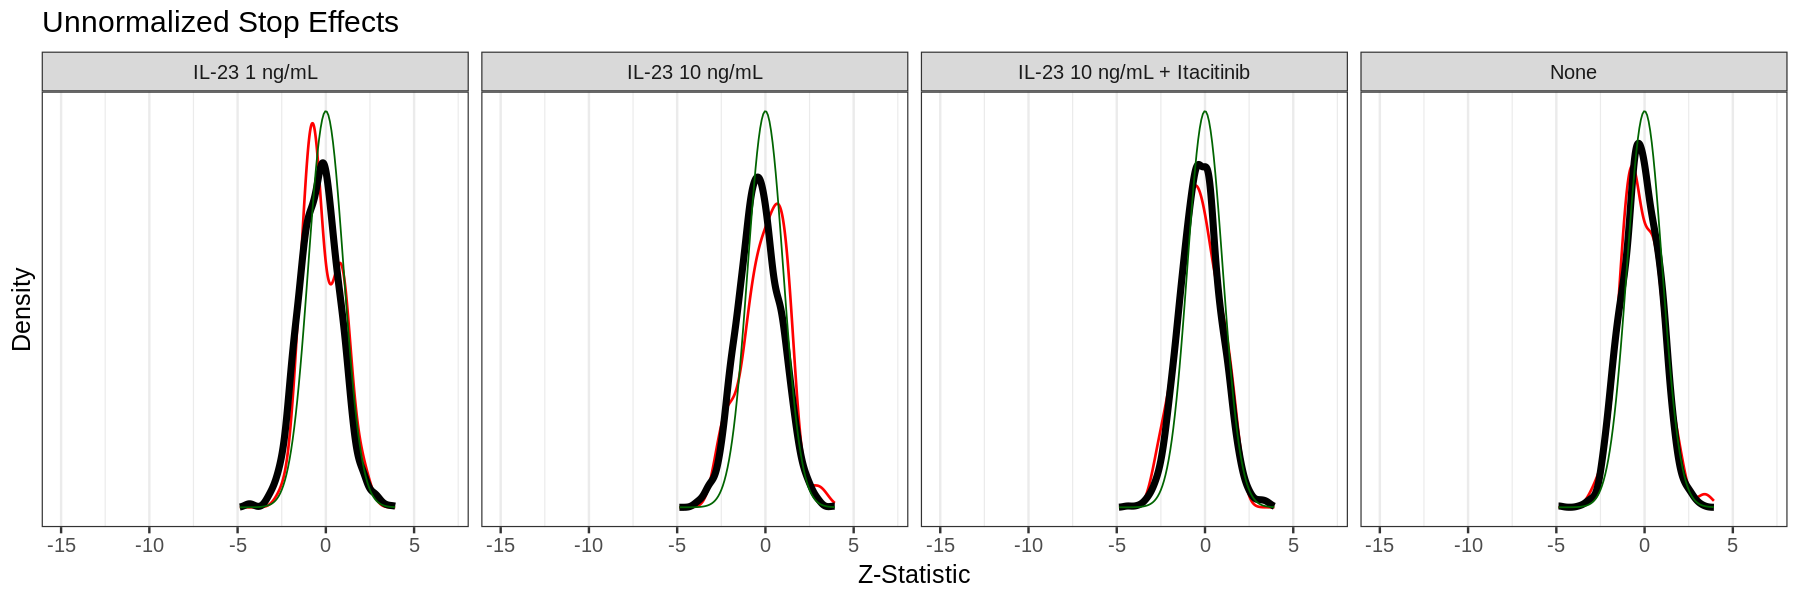

In [139]:
options(repr.plot.width = 15, repr.plot.height = 5)
sumstats %>%
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>% 
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        stat_function(data = data.frame(x = c(-3, 3)), aes(x), color = "darkgreen",
                    fun = dnorm, n = 101, args = list(mean = 0, sd = 1)) +
        scale_y_continuous(breaks = NULL) +
        facet_wrap(~name, ncol = 4) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("Unnormalized Stop Effects") +
        coord_cartesian(xlim = c(-15,7))

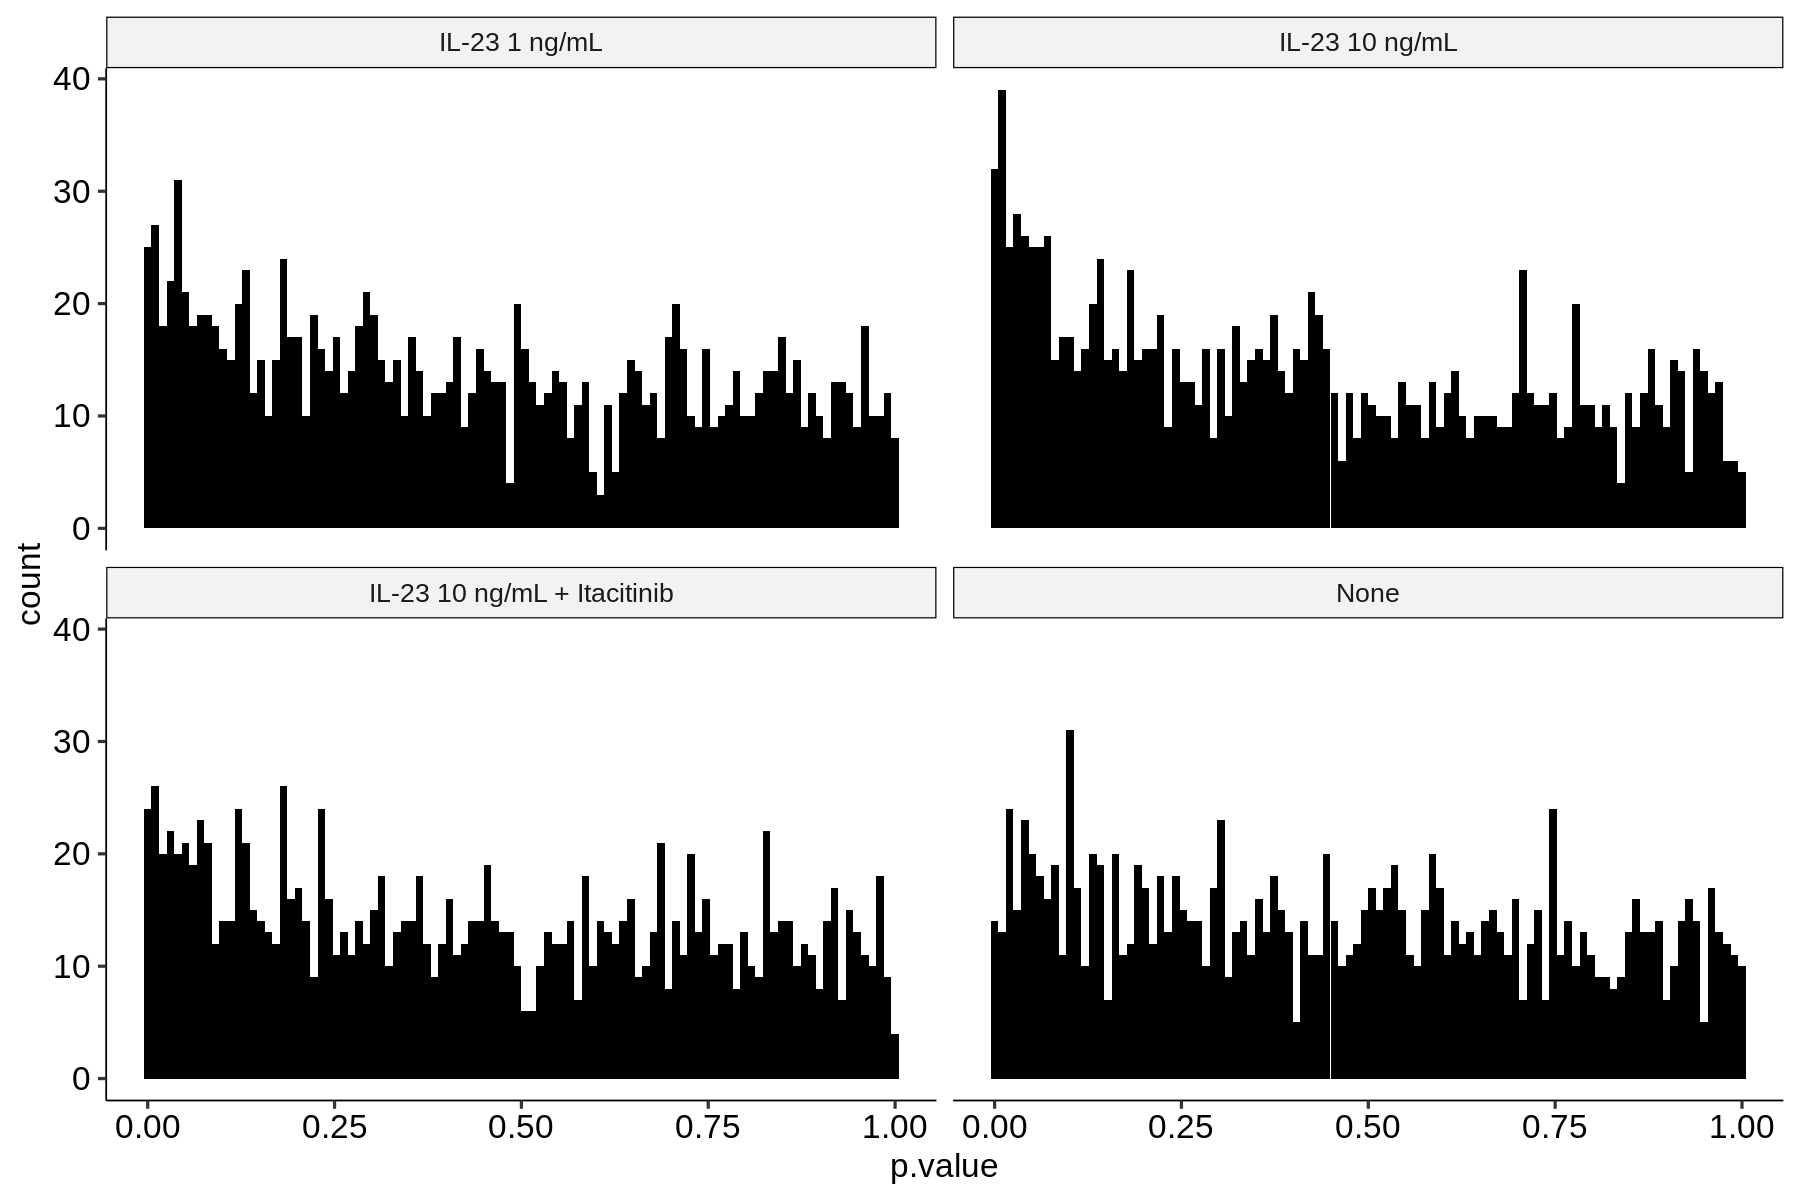

In [140]:
options(repr.plot.width = 15, repr.plot.height = 10)

sumstats %>%
    ggplot() +
        geom_histogram(aes(x = p.value), bins = 100, color = NA, fill = "black") +
        theme_pubr(base_size = 20) +
        facet_wrap(~name)

In [153]:
condition_set <- conditions$condition
noneIdx <- which(conditions == "None0")

sumstats_contr <- map_dfr(condition_set[-noneIdx],
                         ~compute_difference(test = .,
                                            control = "None0",
                                            sumstats = sumstats)) %>%
    mutate(condition = factor(condition, levels = c("IL231 - None0",
                                                    "IL2310 - None0",
                                                    "IL23+Itacitinib10 - None0")),
           statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

sumstats_contr %>% write_tsv("../sumstats/TYK2/run9/tyk2-assay9.tsv")

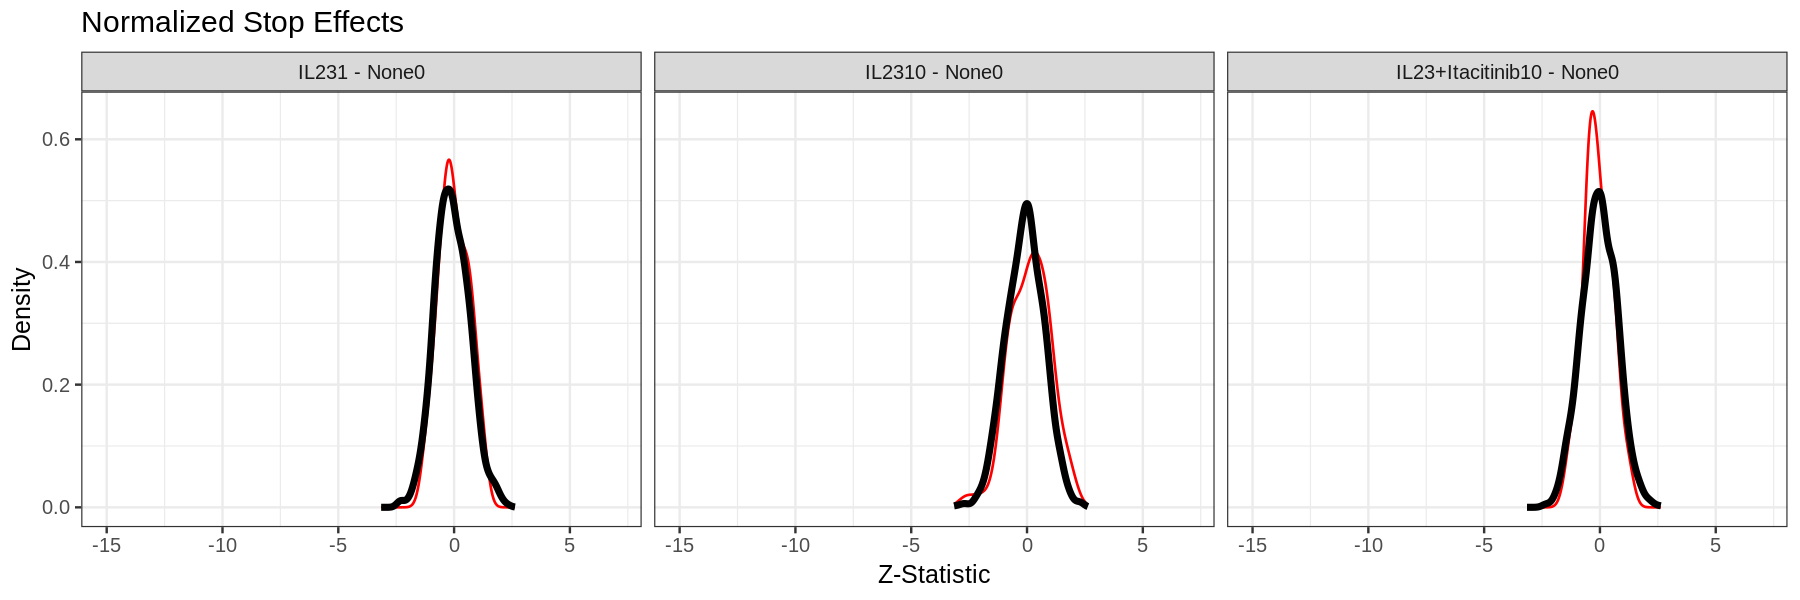

In [148]:
options(repr.plot.width = 15, repr.plot.height = 5)
sumstats_contr %>%
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>%
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        facet_wrap(~condition, ncol = 3) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("Normalized Stop Effects") +
        coord_cartesian(xlim = c(-15,7))

We can also examine directly the number of variants across all comparisons that are significant at a 1% FDR:

In [151]:
sumstats_contr %>%
    count(direction = if_else(estimate > 0, "GoF", "LoF"),
          sig = if_else(p.adj < 0.01, "Significant (FDR < 0.01)", "Non-Significant")) %>%
    pivot_wider(names_from = sig, values_from = n, values_fill = 0) %>%
    kable(type = "markdown", digits = 10)



|direction | Non-Significant|
|:---------|---------------:|
|GoF       |            1946|
|LoF       |            2248|

### Visualizations <a name="part3"></a>

In [154]:
sumstats <- read_tsv("../sumstats/TYK2/run9/tyk2-assay9-unnormalized.tsv")
sumstats_all <- read_tsv("../sumstats/TYK2/run9/tyk2-assay9.tsv")

Rows: 5592 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, condition, aa, version, name
dbl (8): pos, chunk, estimate, std.error, statistic, p.value, dispersion, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4194 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): clone, aa, version, condition
dbl (8): pos, chunk, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


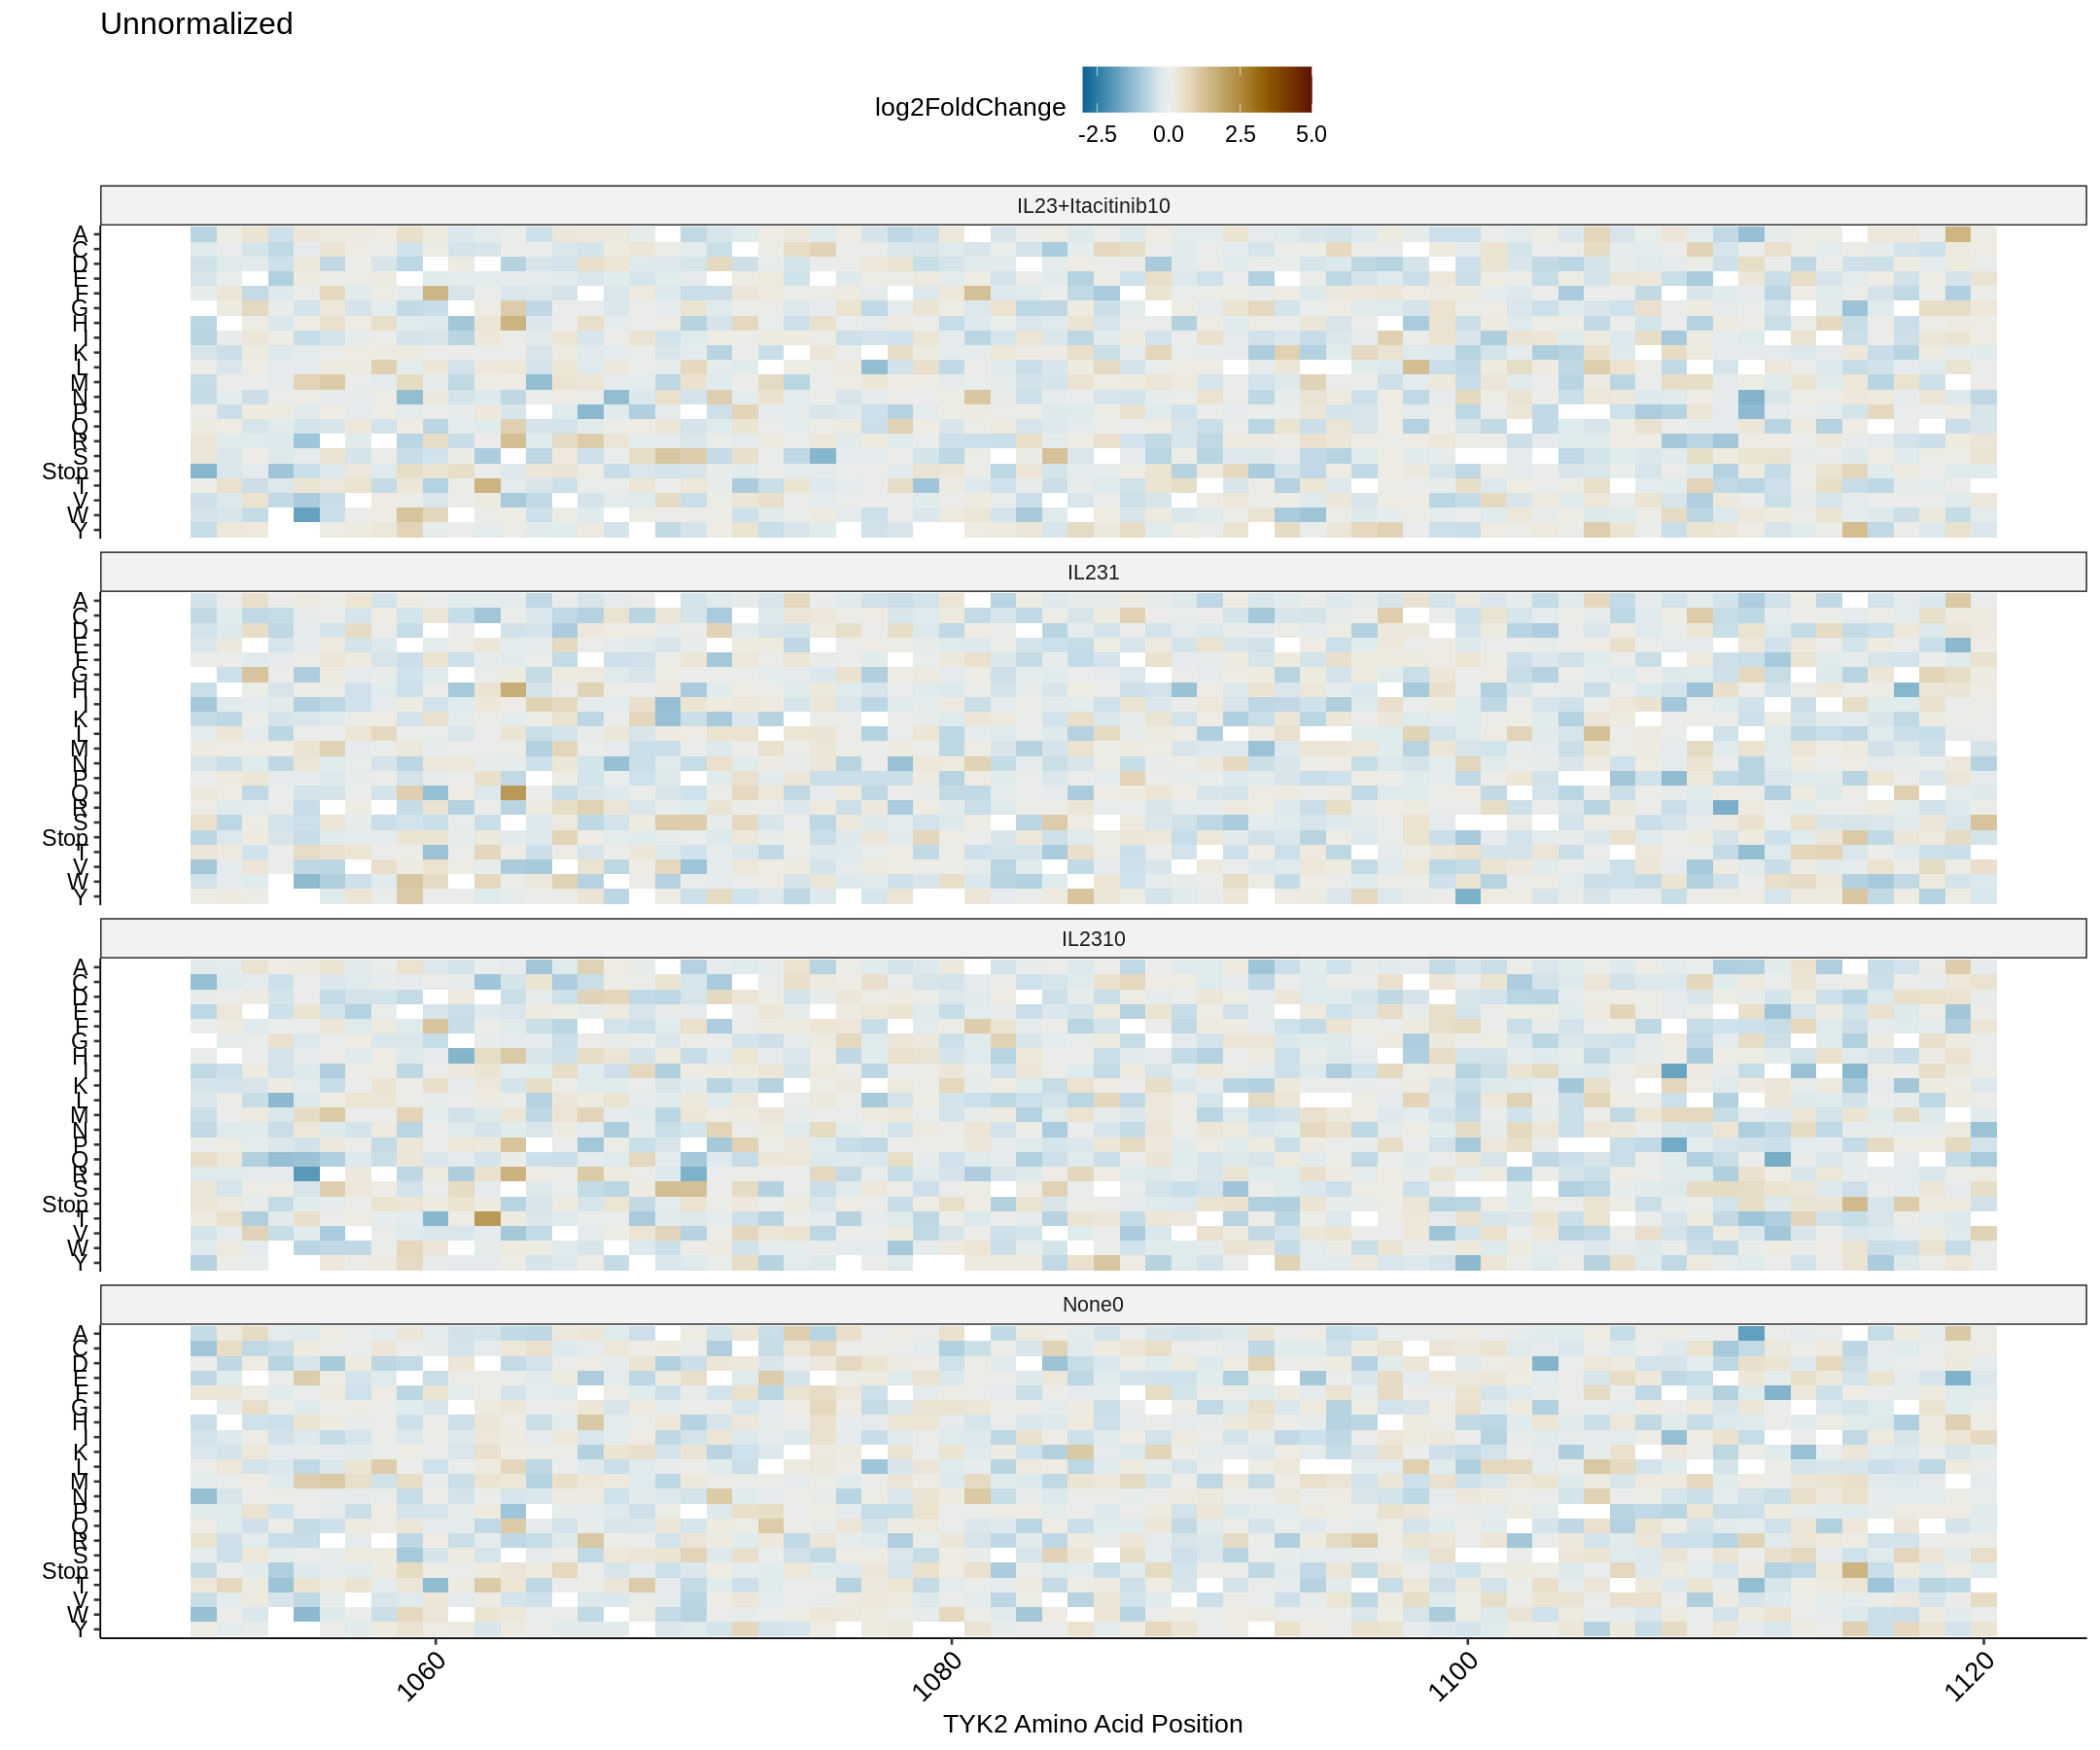

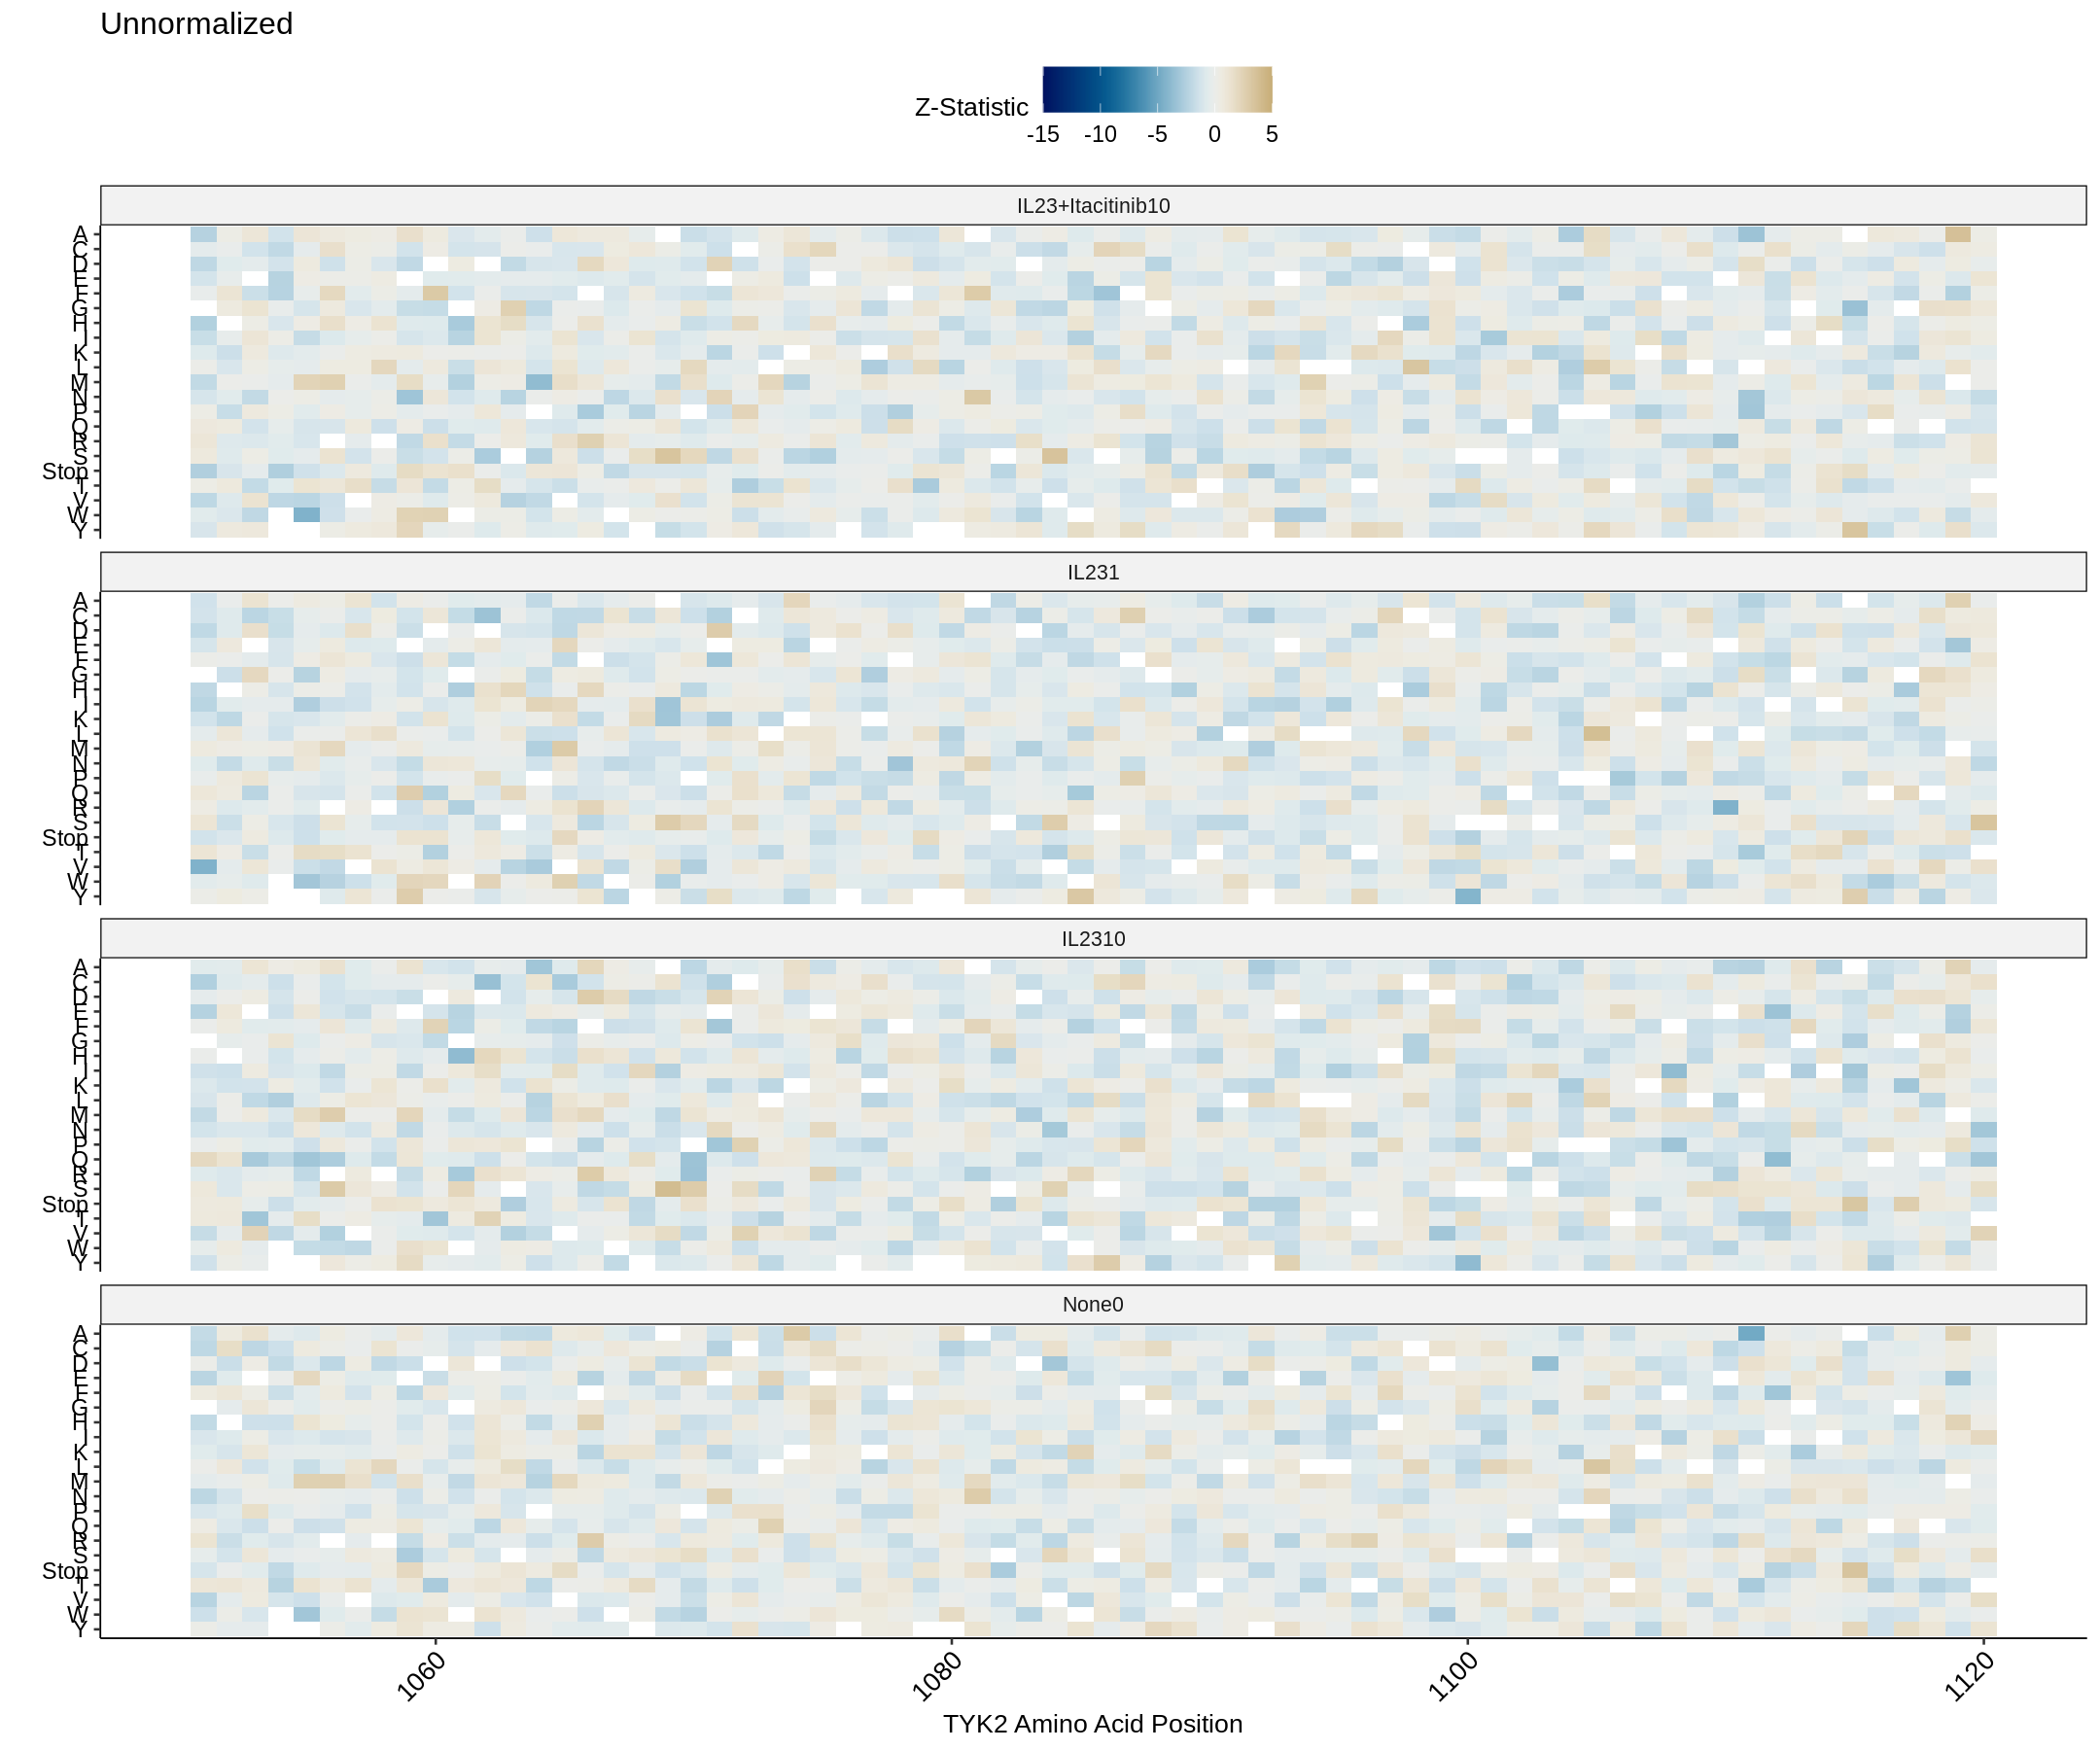

In [155]:
options(repr.plot.width = 18, repr.plot.height = 15)

sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =log2FoldChange)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Unnormalized")

sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Unnormalized")

In [158]:
norm_heat_l2fc <- sumstats_all %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = log2FoldChange)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to None")

norm_heat_z <- sumstats_all %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to None")

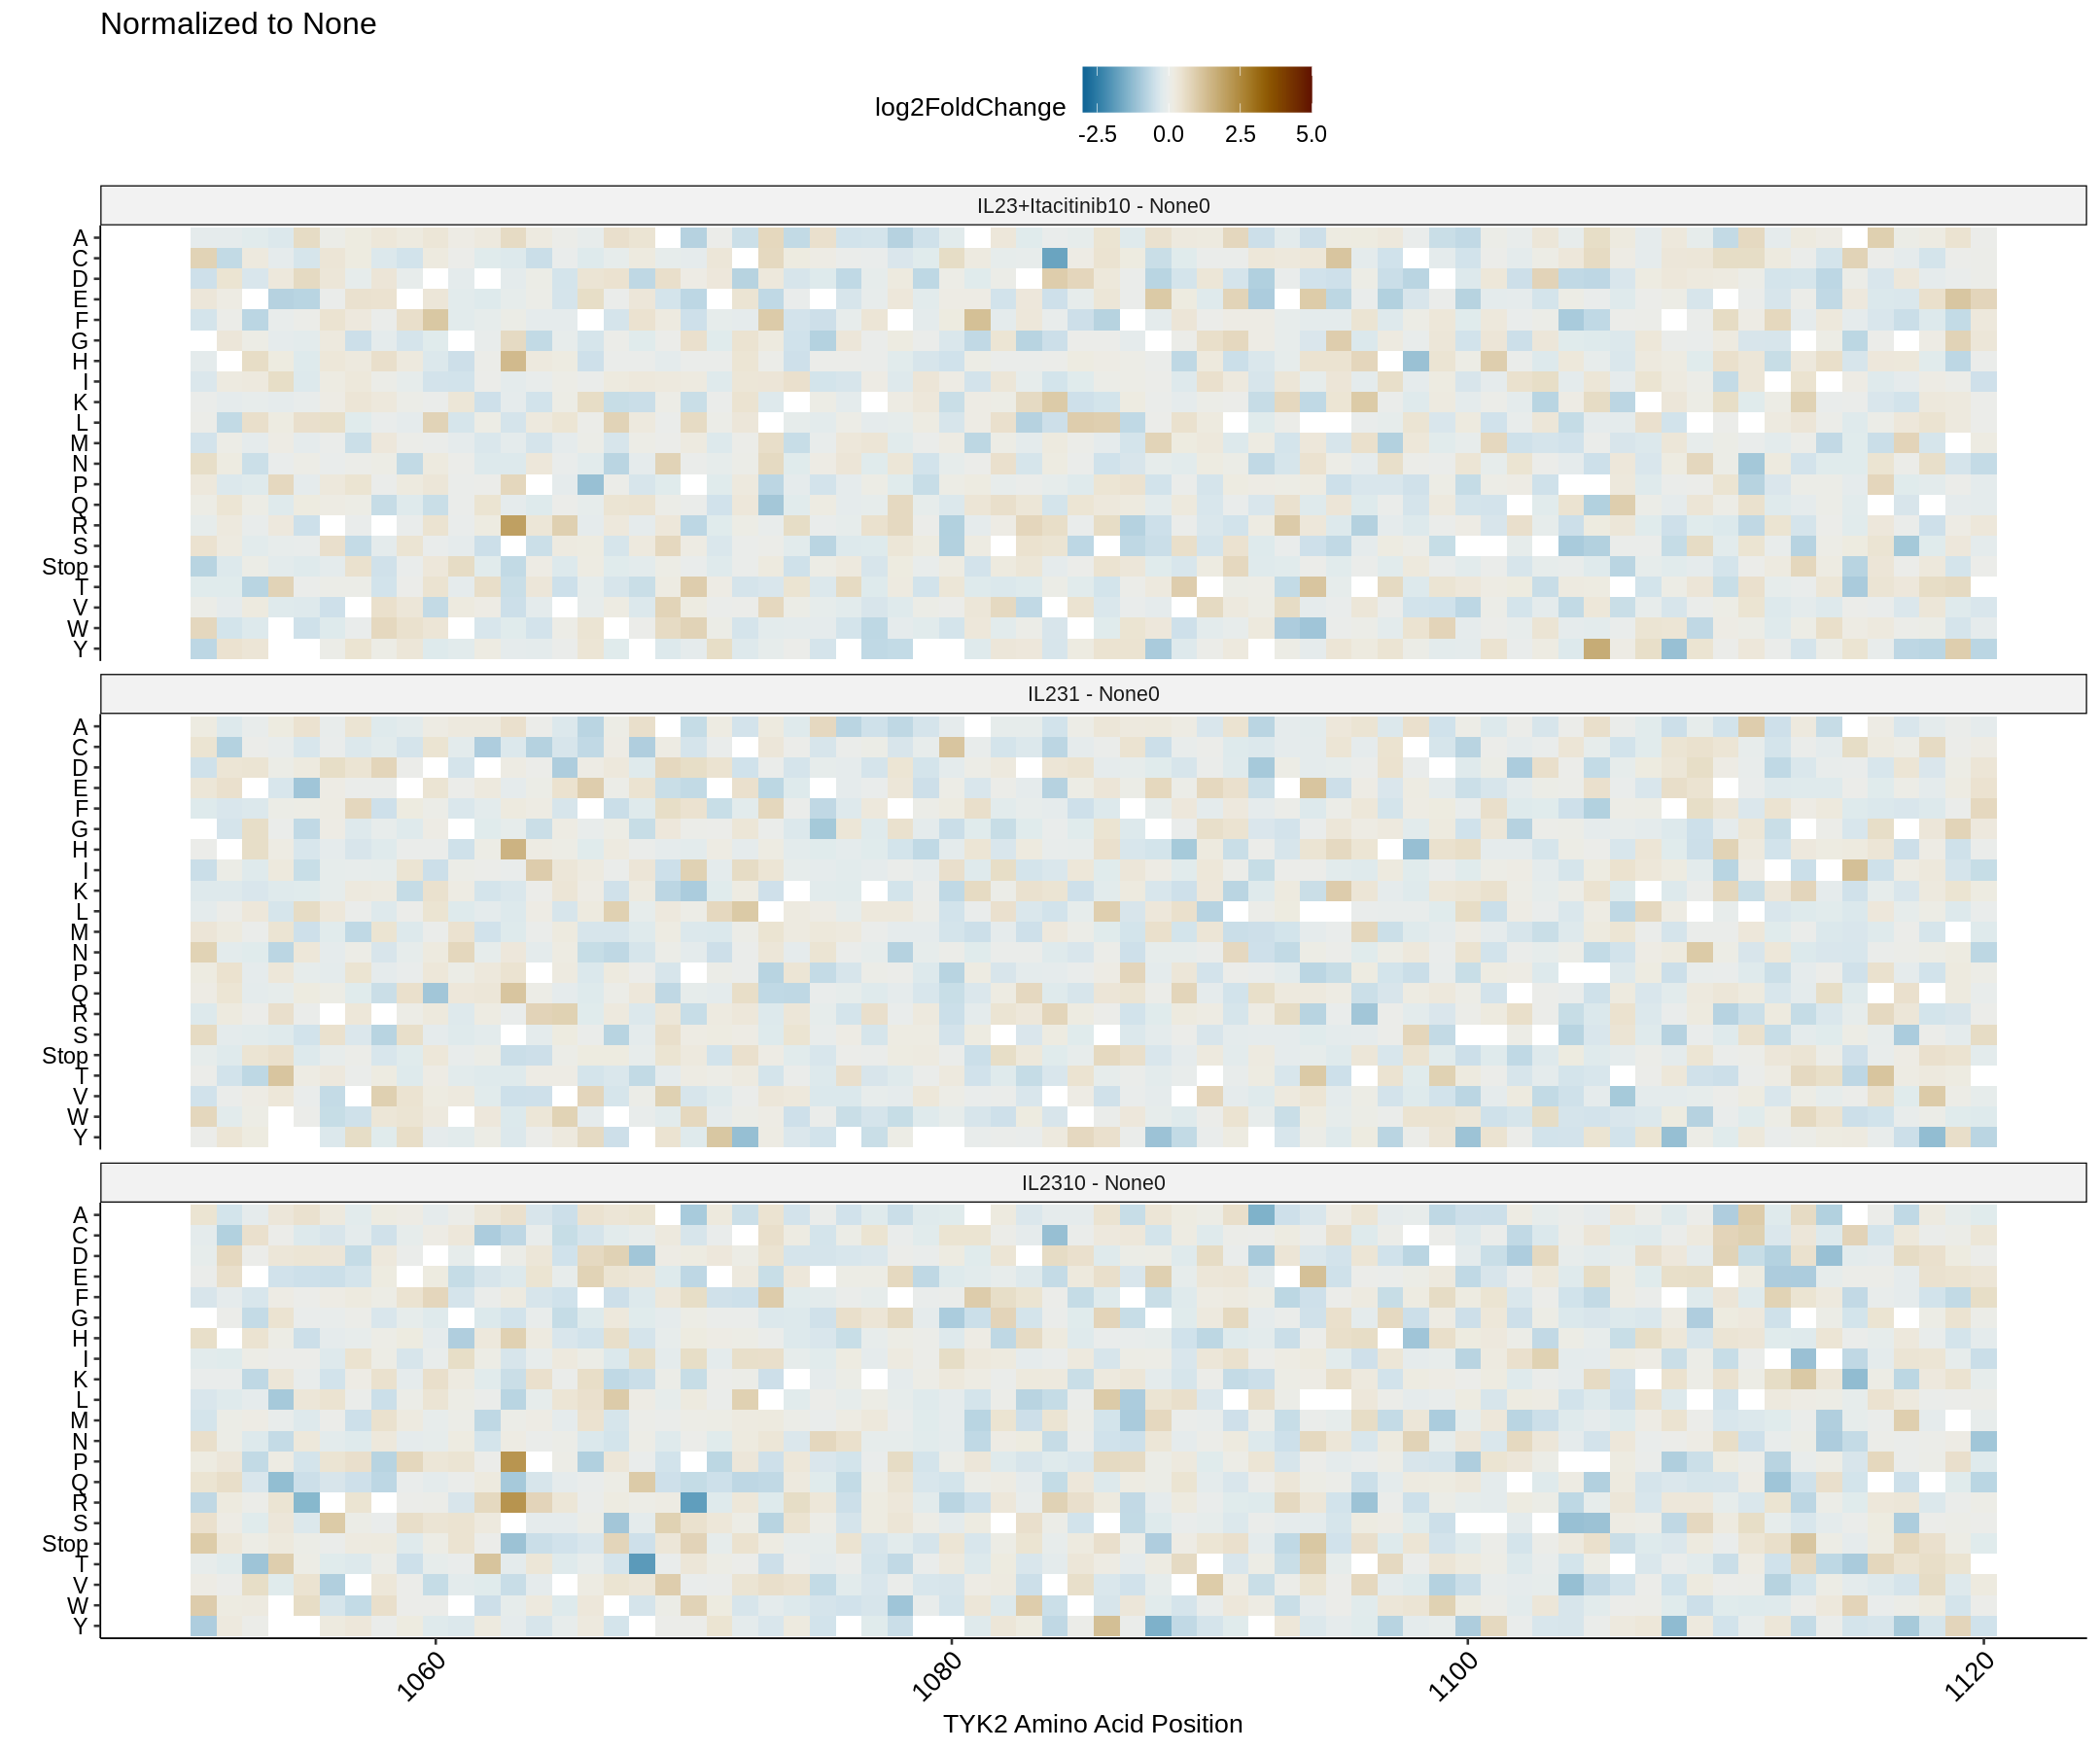

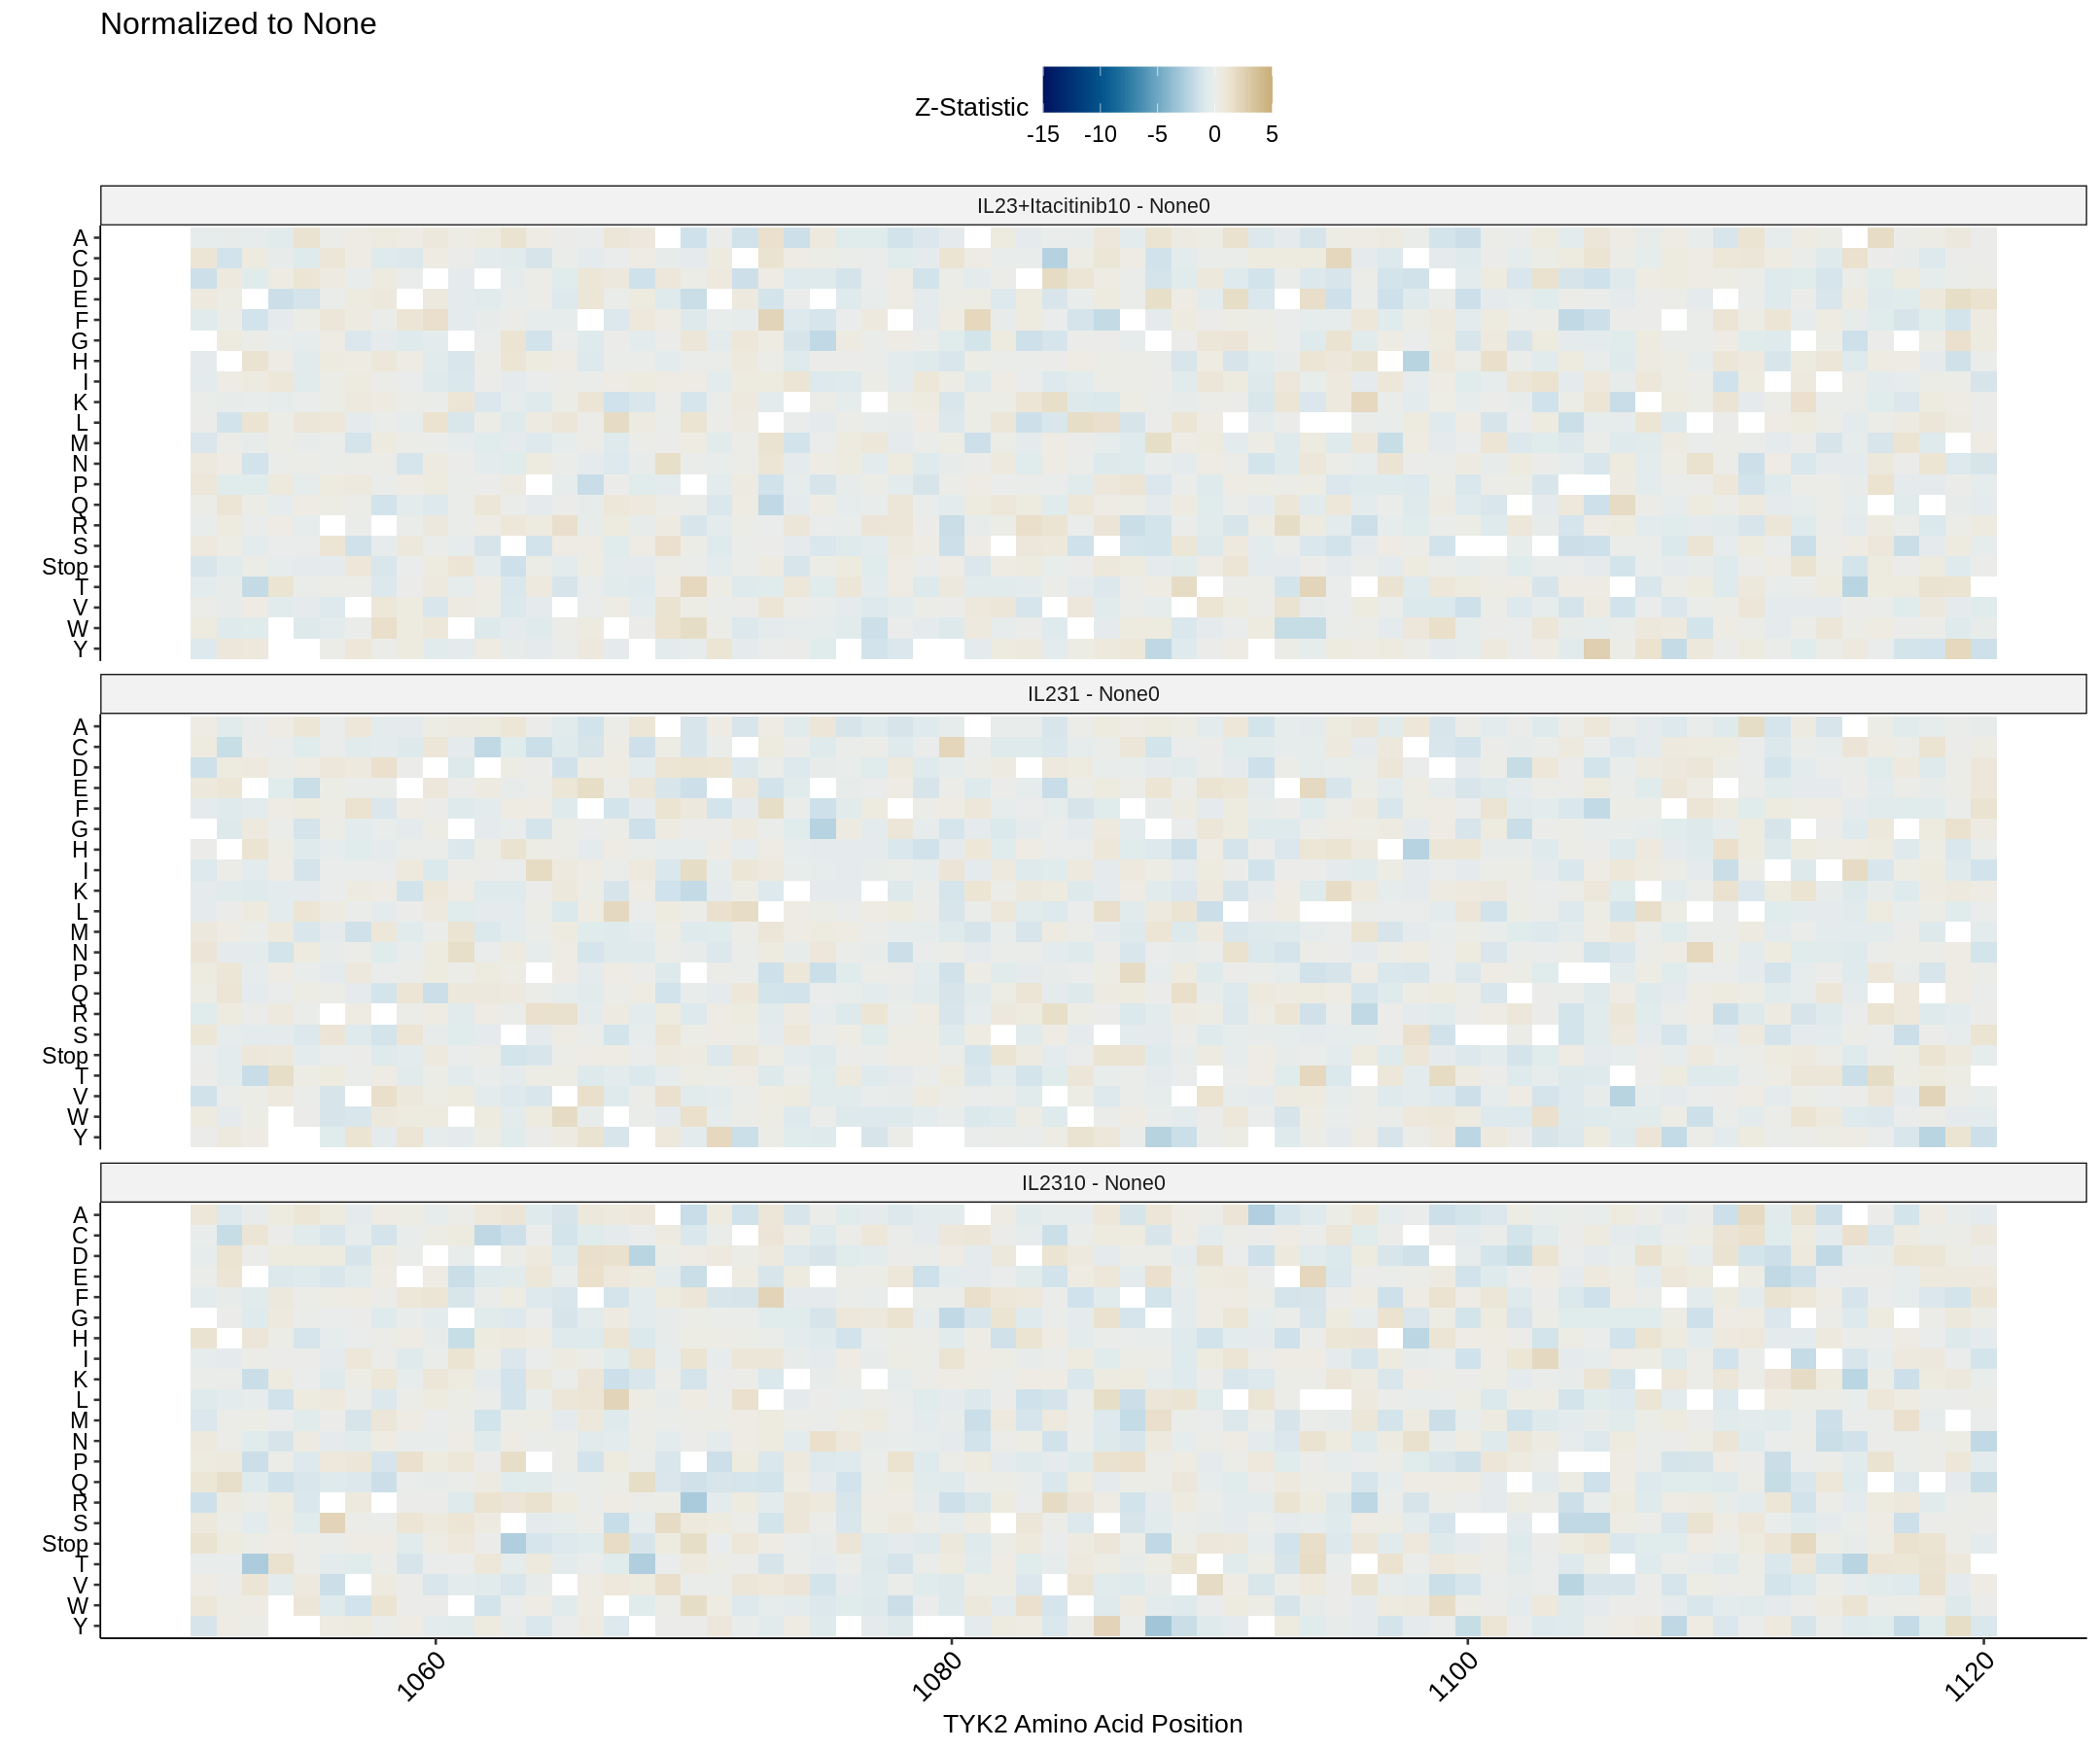

In [159]:
options(repr.plot.width = 18, repr.plot.height = 15)
norm_heat_l2fc
norm_heat_z

### Raw Data Review <a name="part4"></a>

To be sure the model isn't doing something unusual, we extract the raw barcode counts for three variants (WT, P1104A, and P1104Stop) and compare them. Below are the distributions of those raw counts across samples:

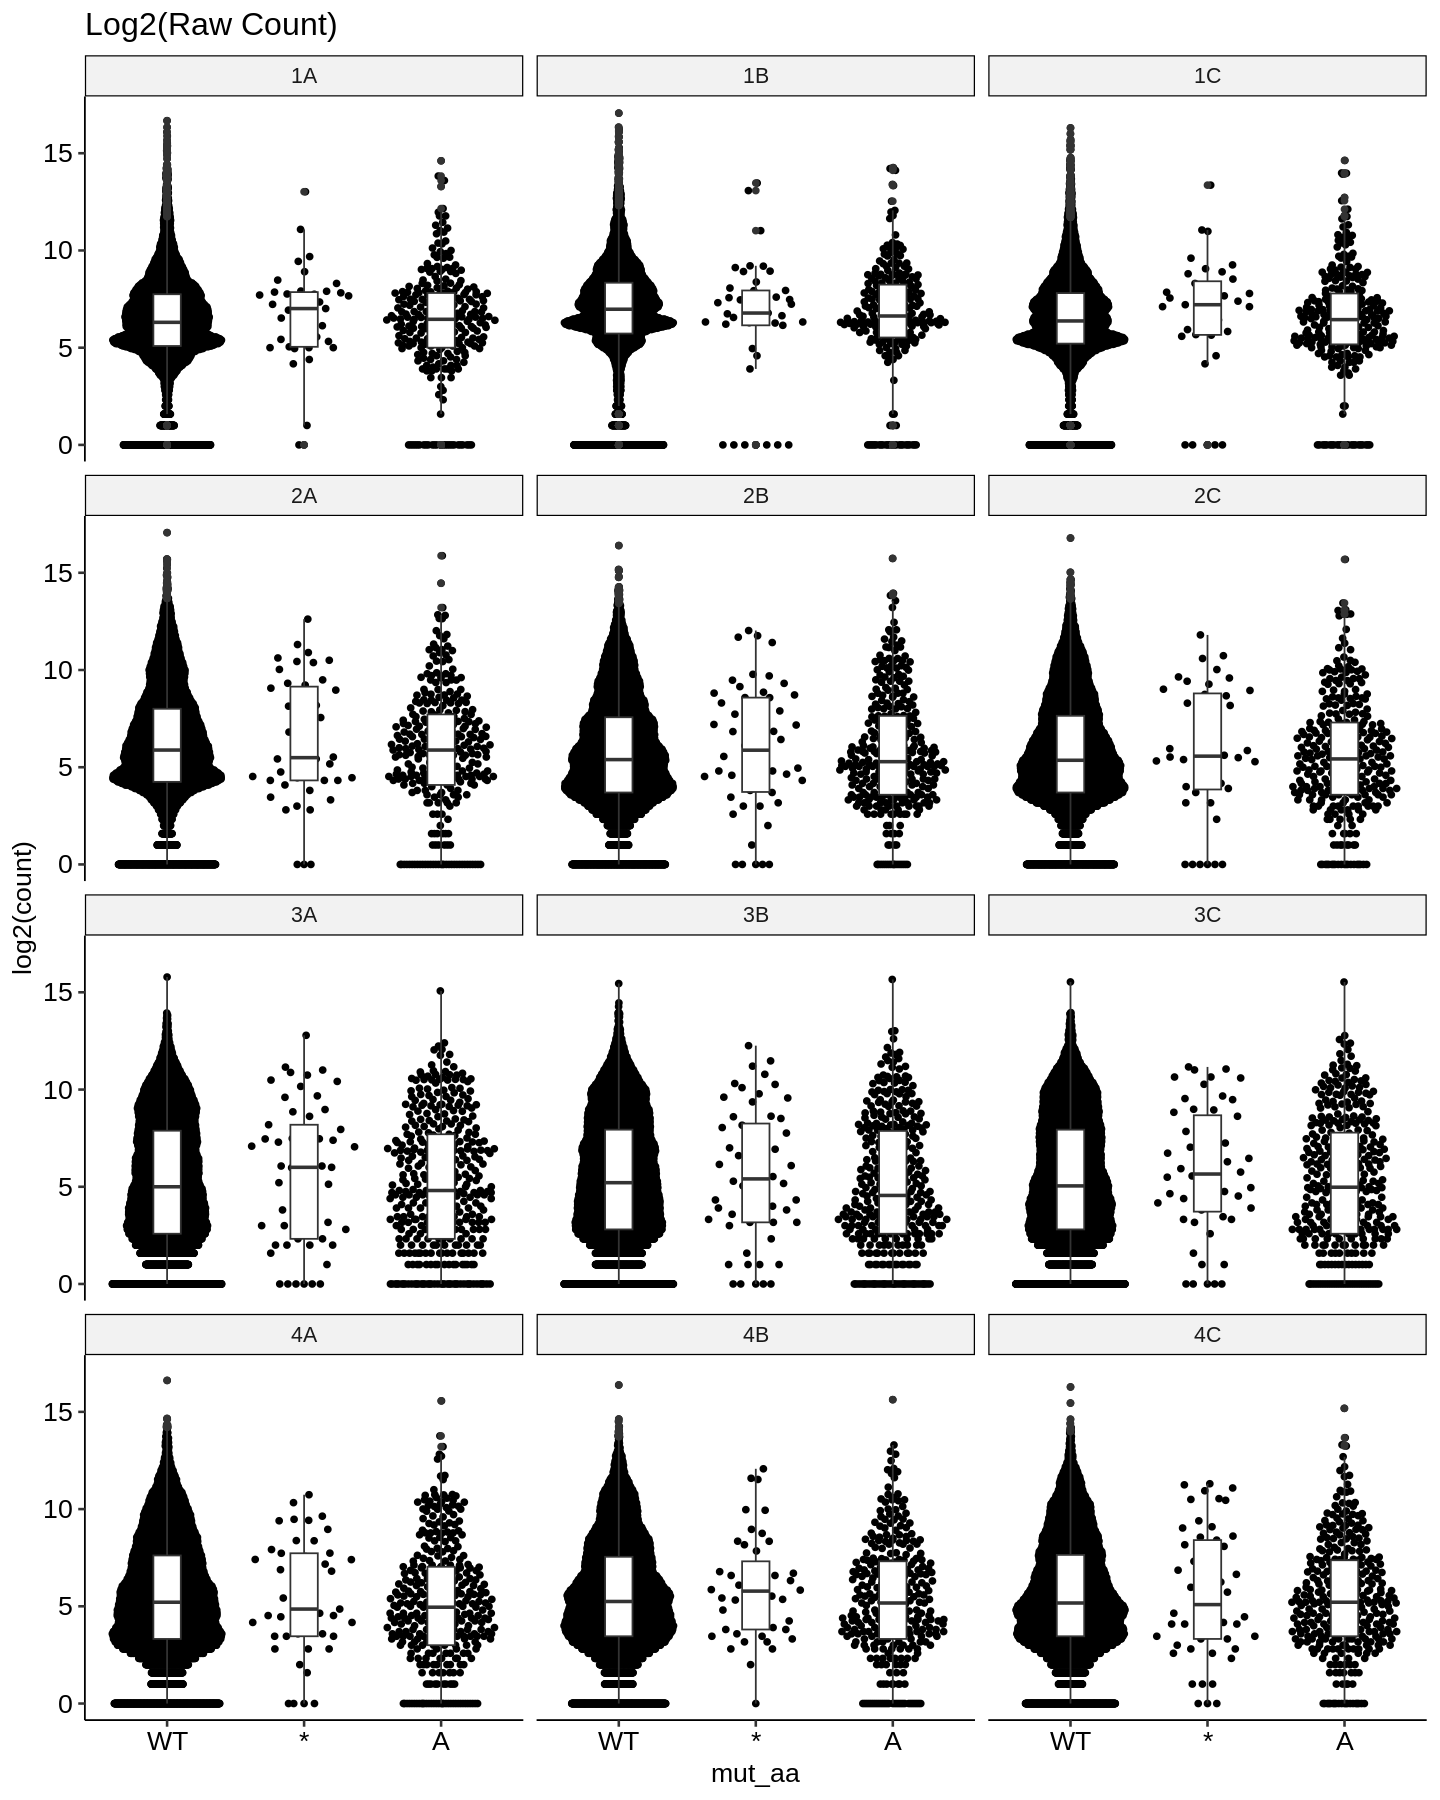

In [112]:
options(repr.plot.width = 12, repr.plot.height = 15)

mapped_counts %>% 
    filter((pos == 1104 & mut_aa %in% c("*", "A")) | mut_aa == "WT") %>%
    ggplot() +
        geom_quasirandom(aes(x = mut_aa, y = log2(count))) +
        geom_boxplot(aes(x = mut_aa, y = log2(count)), width = 0.2) +
        theme_pubr(base_size = 16) +
        facet_wrap(~sample, ncol = 3) +
        ggtitle("Log2(Raw Count)")

Another simple raw data view is to take the raw counts and subtract the barcode average from each barcode. This generates a "barcode-centered" log count, which can make it easier to see trends in the raw data:

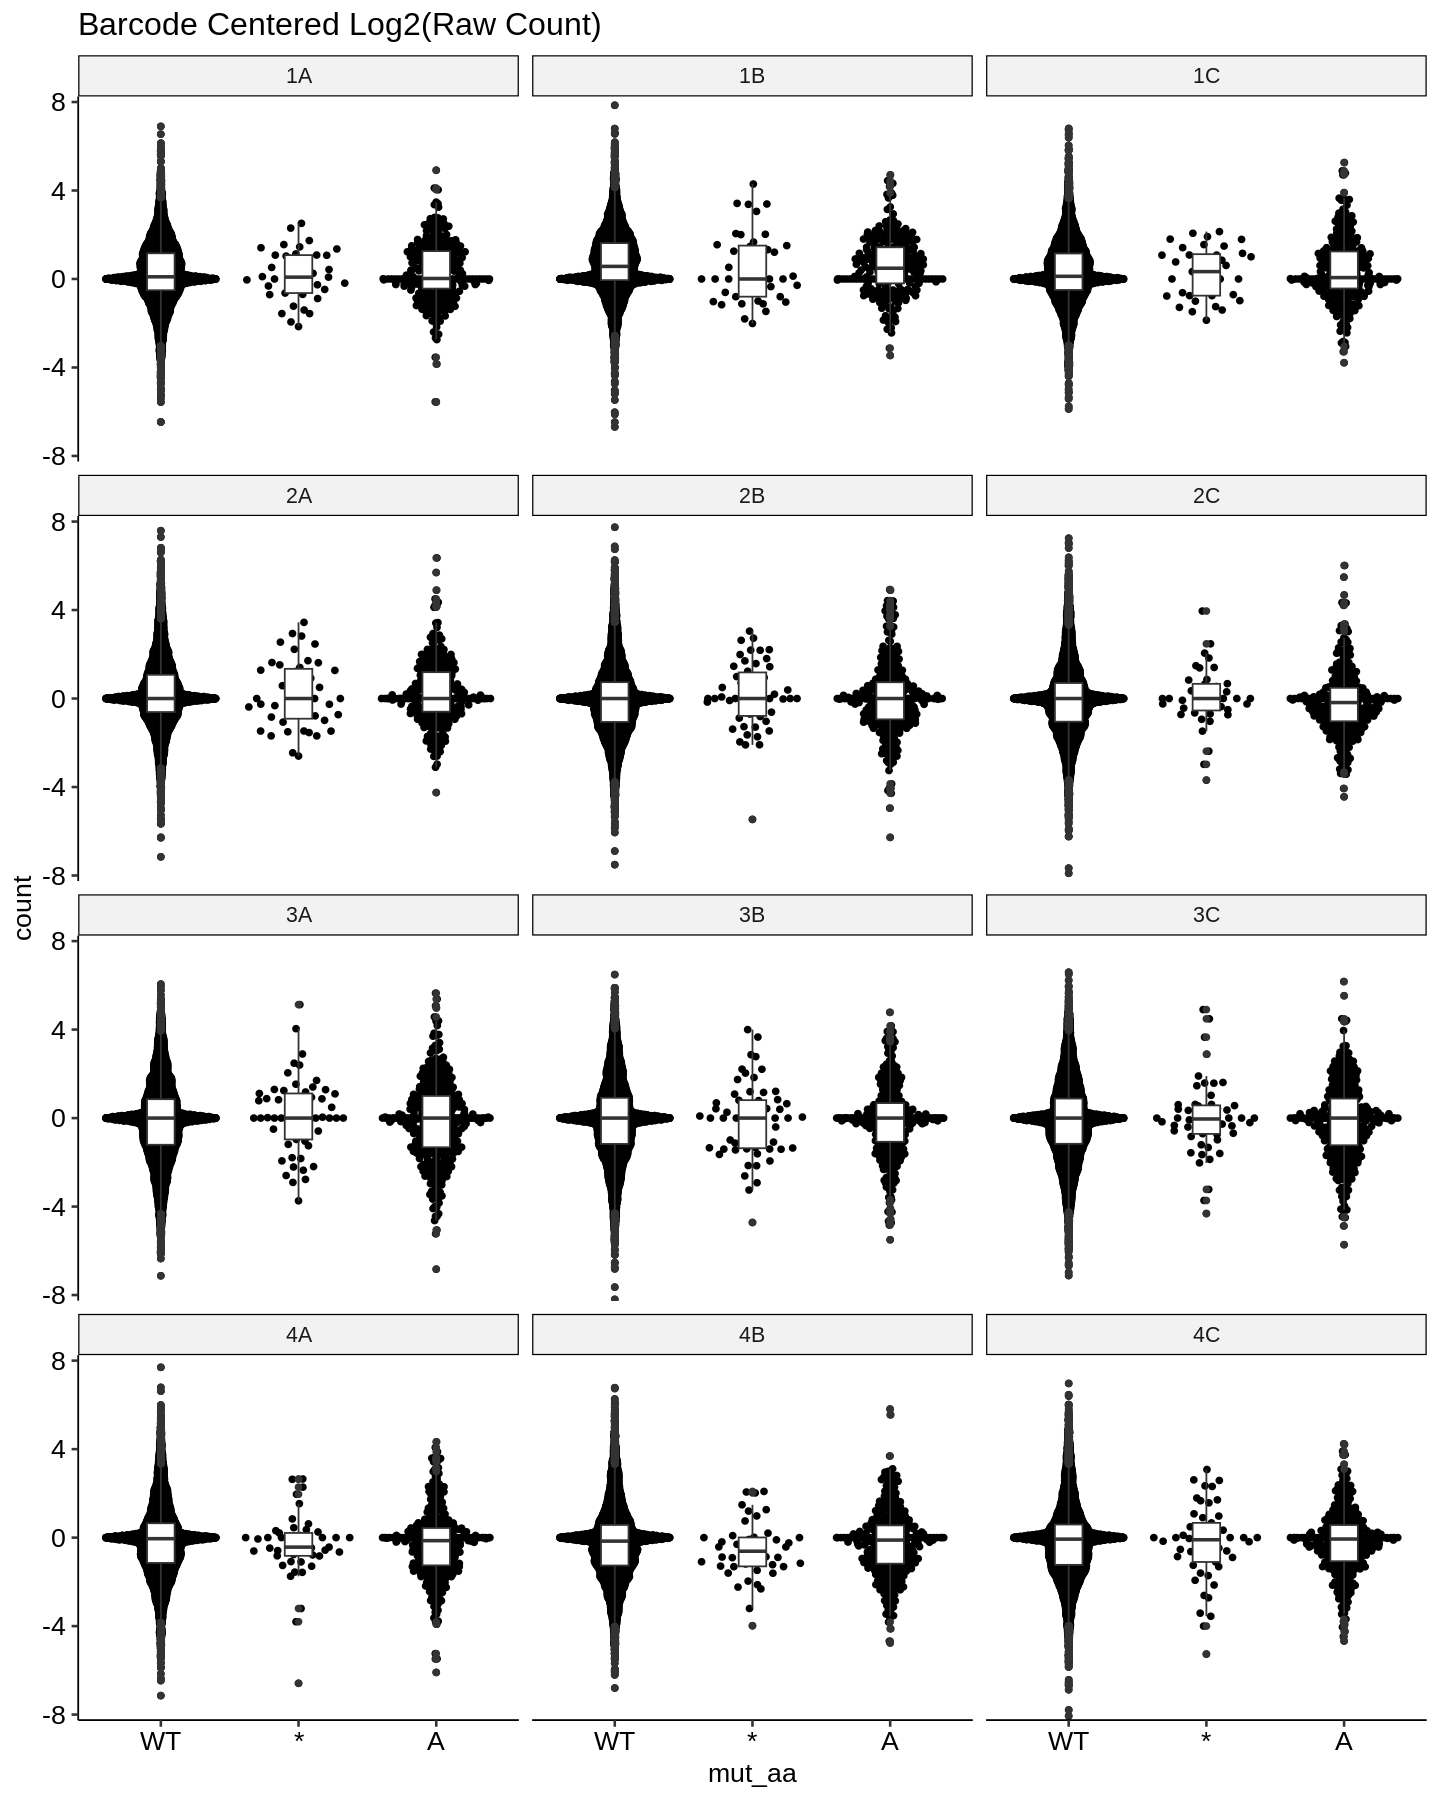

In [113]:
options(repr.plot.width = 12, repr.plot.height = 15)

mapped_counts %>% 
    filter((pos == 1104 & mut_aa %in% c("*", "A")) | mut_aa == "WT") %>%
    group_by(barcode) %>%
    mutate(count = log2(count) - mean(log2(count))) %>%
    ggplot() +
        geom_quasirandom(aes(x = mut_aa, y = count)) +
        geom_boxplot(aes(x = mut_aa, y = count), width = 0.2) +
        theme_pubr(base_size = 16) +
        facet_wrap(~sample, ncol = 3) +
        ggtitle("Barcode Centered Log2(Raw Count)") +
        coord_cartesian(ylim = c(-7.5, 7.5))

To get an intuition for what a variant effect would look like in the raw counts, we can extract the same counts for the same positions from the IFN-alpha 100 U/mL condition in Assay 3. In comparison, we have far more barcodes per variant in the mini-DMS as expected, but the stop-specific shift is very clear:

In [96]:
mapped_counts_compare <- vroom(str_c("../pipeline/OCNT-DMSLIB-1-assay-run3/combined/tyk2-form-16.mapped-counts.tsv"),
                          col_names = c("sample", "barcode", "lib", "chunk", 
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon",
                                        "condition", "clone", "dox", "condition_conc", "count"))  %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT"))

Rows: 526232 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, condition...
dbl (5): chunk, pos, dox, condition_conc, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


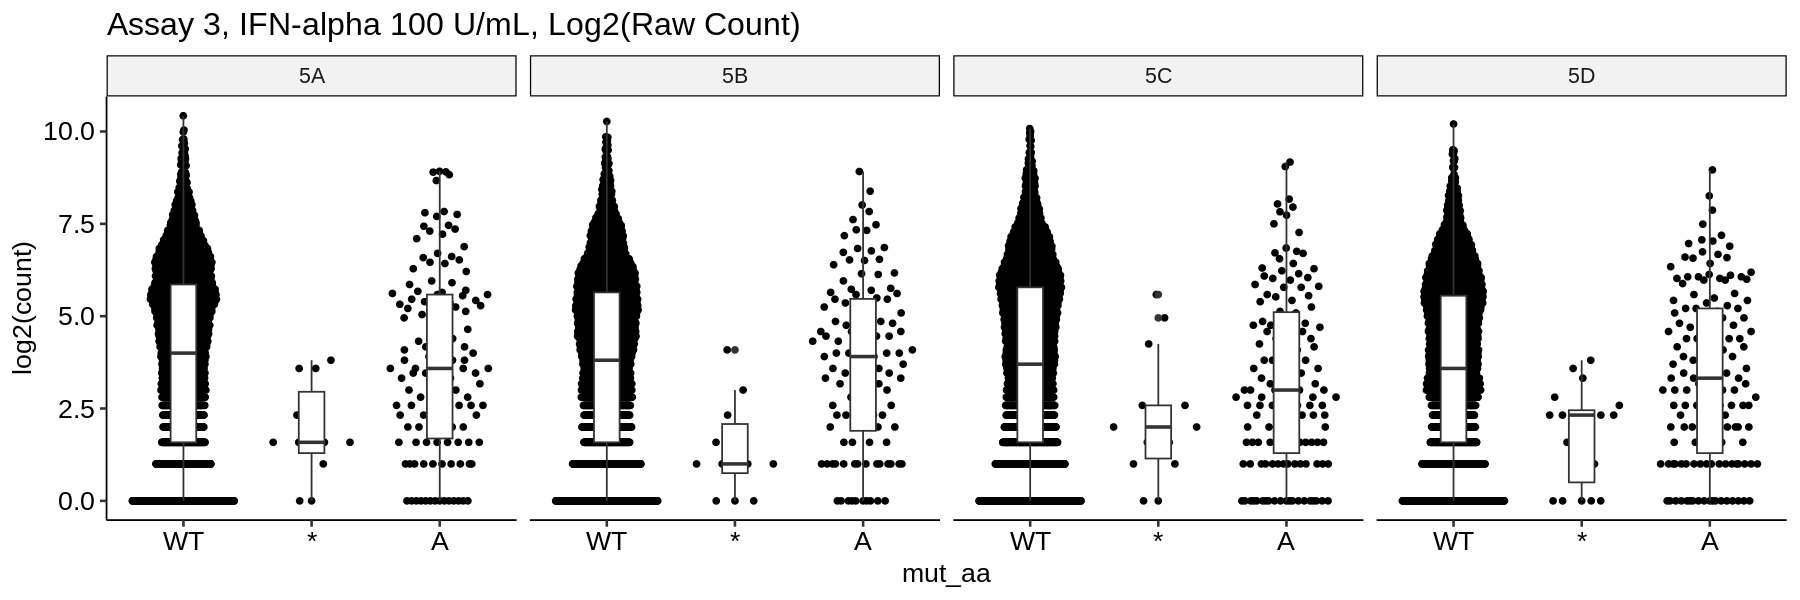

In [97]:
options(repr.plot.width = 15, repr.plot.height = 5)

mapped_counts_compare %>% 
    filter((pos == 1104 & mut_aa %in% c("*", "A")) | mut_aa == "WT") %>%
    filter(grepl("5", sample)) %>%
    ggplot() +
        geom_quasirandom(aes(x = mut_aa, y = log2(count))) +
        geom_boxplot(aes(x = mut_aa, y = log2(count)), width = 0.2) +
        theme_pubr(base_size = 16) +
        facet_wrap(~sample, ncol = 4) +
        ggtitle("Assay 3, IFN-alpha 100 U/mL, Log2(Raw Count)")

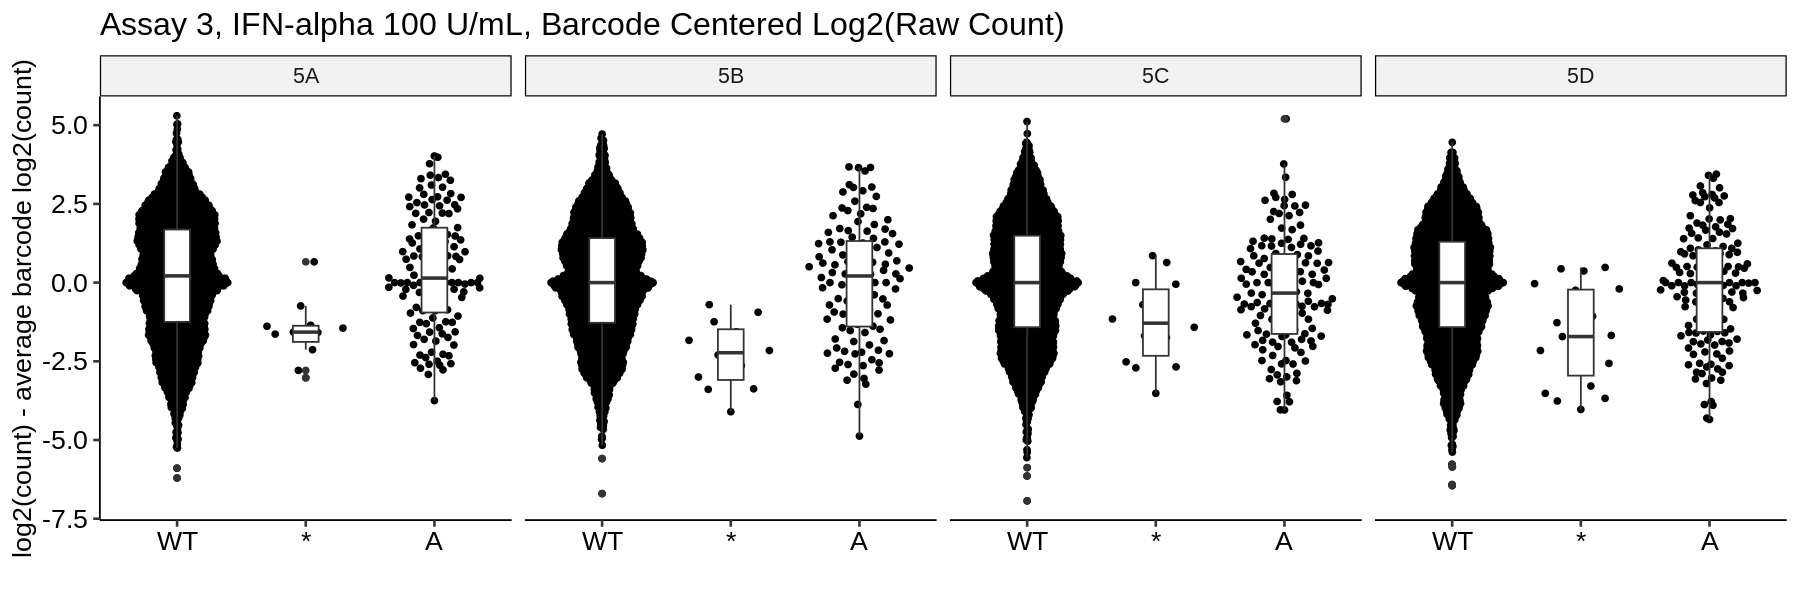

In [110]:
options(repr.plot.width = 15, repr.plot.height = 5)
mapped_counts_compare %>% 
    filter((pos == 1104 & mut_aa %in% c("*", "A")) | mut_aa == "WT") %>%
    group_by(barcode) %>%
    mutate(count = log2(count) - mean(log2(count))) %>%
    filter(grepl("5", sample)) %>%
    ggplot() +
        geom_quasirandom(aes(x = mut_aa, y = count)) +
        geom_boxplot(aes(x = mut_aa, y = count), width = 0.2) +
        theme_pubr(base_size = 16) +
        facet_wrap(~sample, ncol = 4) +
        ggtitle("Assay 3, IFN-alpha 100 U/mL, Barcode Centered Log2(Raw Count)") +
        xlab("") + ylab("log2(count) - average barcode log2(count)")

For completion, we can extract the summary statitics for position 1104 and view them directly:

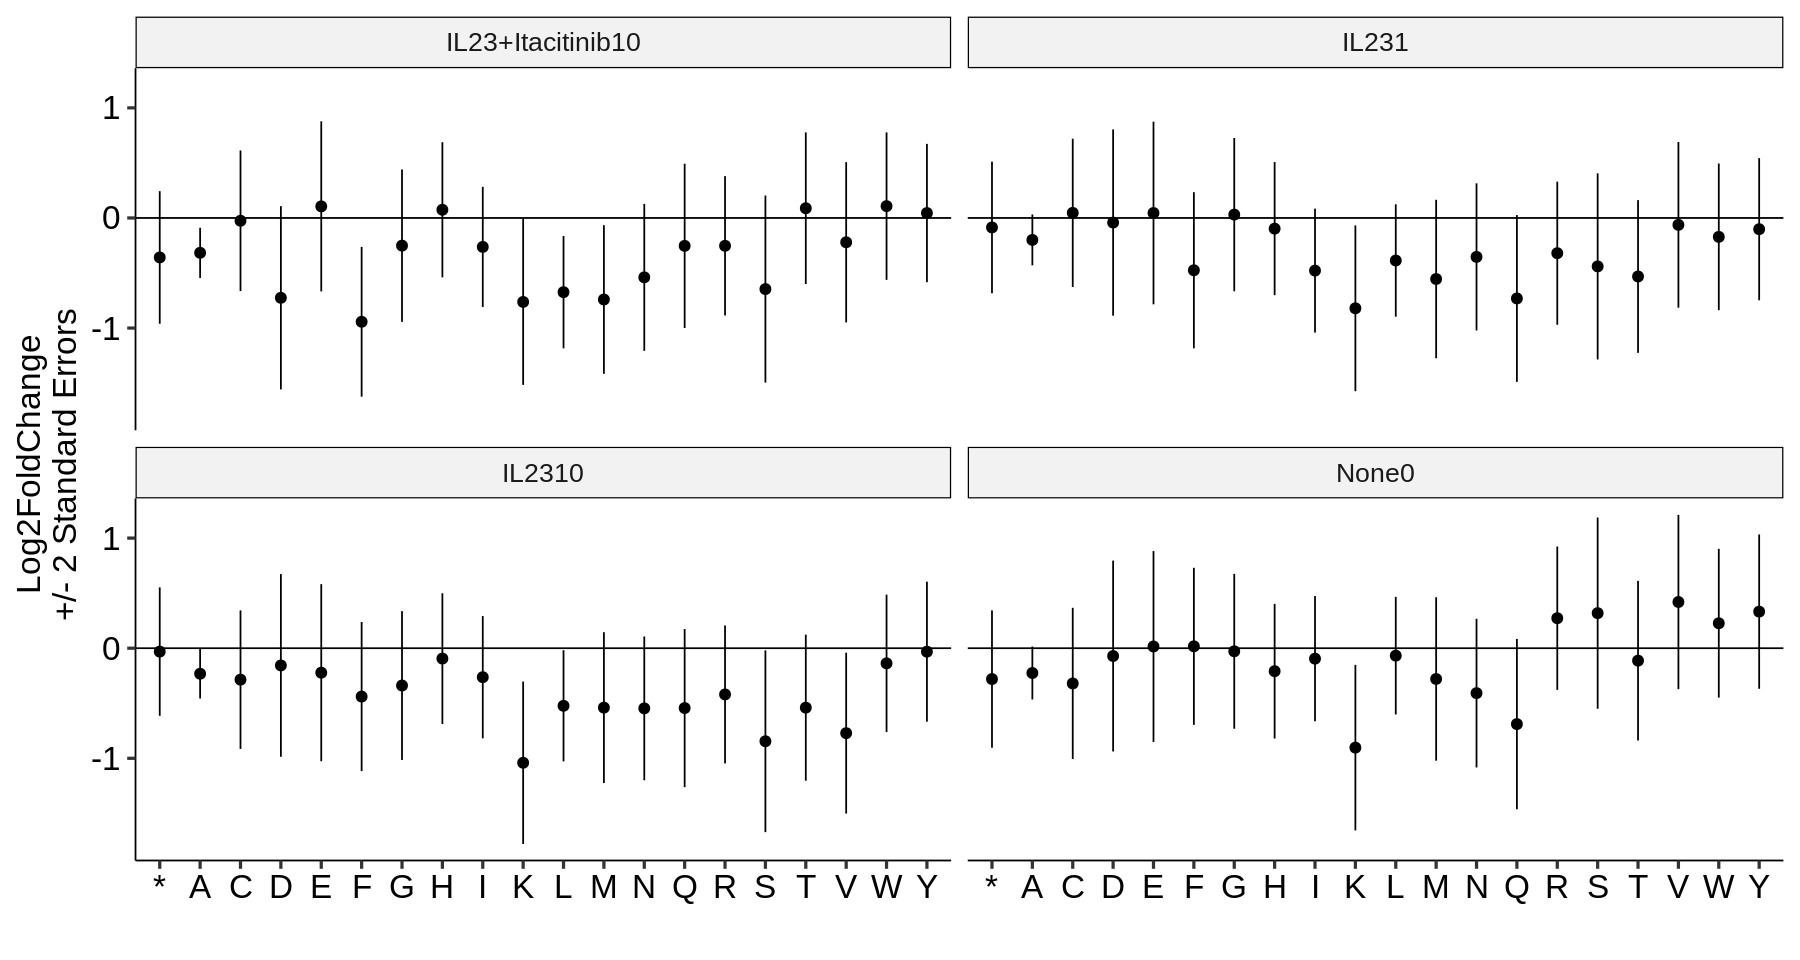

In [109]:
options(repr.plot.width = 15, repr.plot.height = 8)

sumstats %>%
    filter(pos == "1104") %>%
    ggplot() +
        geom_pointrange(aes(x = aa, y = estimate,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error)) +
        facet_wrap(~condition) +
        theme_pubr(base_size = 20) +
        geom_hline(yintercept = 0) +
        xlab("") + ylab("Log2FoldChange\n+/- 2 Standard Errors")

We observe the variance reduction for P1104A but no convincing significant effects. Finally, we can compare the Z-statistics between IL-23 10 ng/mL and IL-23 10 ng/mL + Itacitinib to evaluate whether any itacitinib-specific variant groups appear, which does not seem to be the case. Below, stops are highlighted in red:

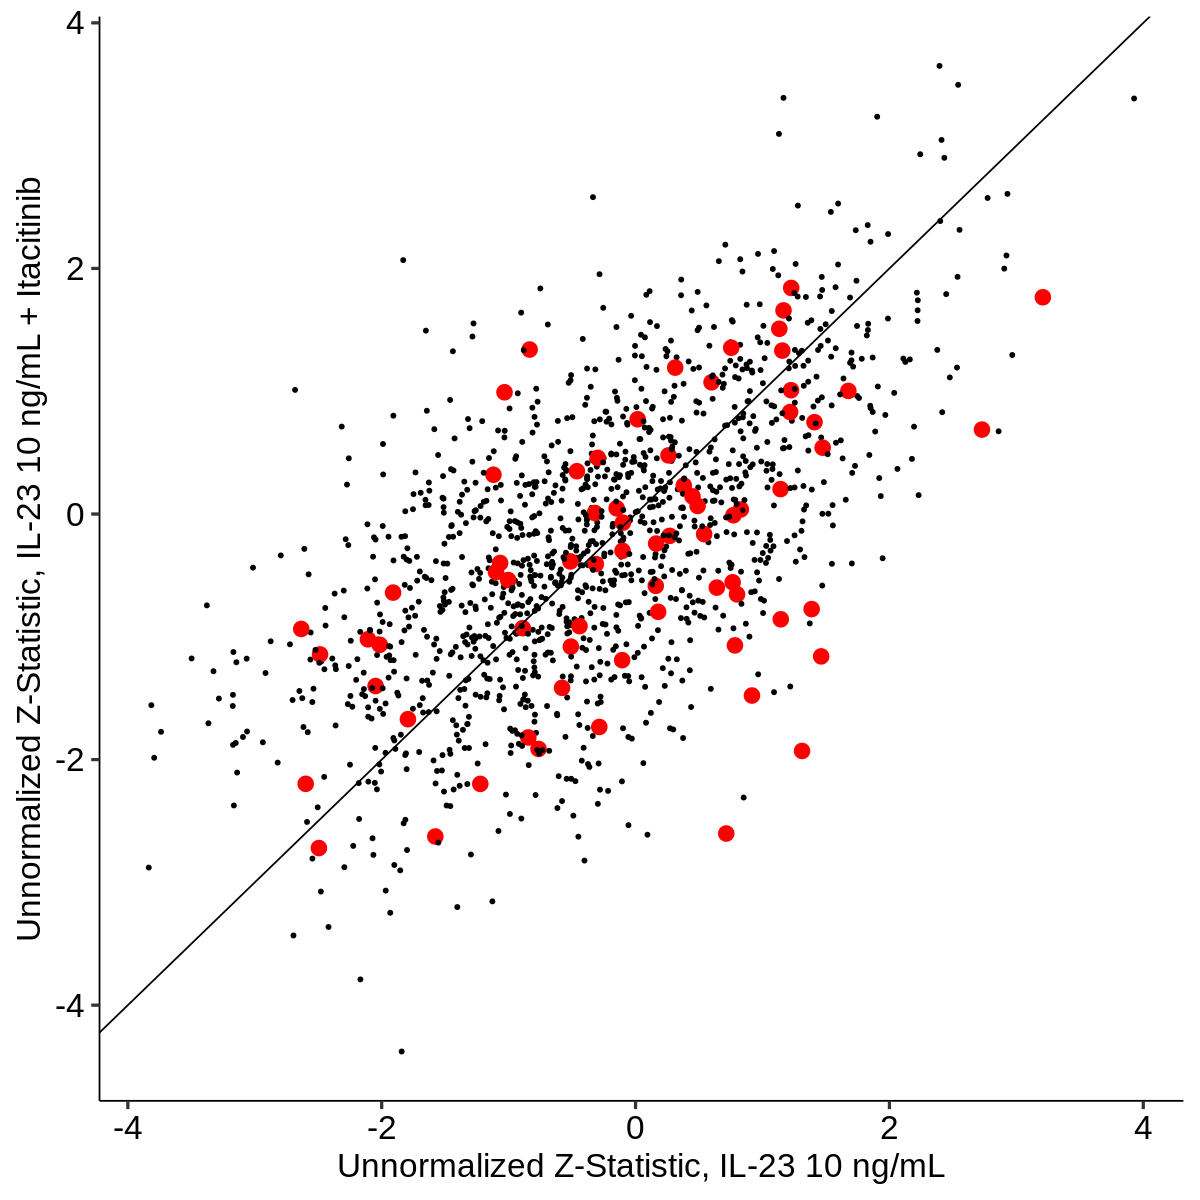

In [114]:
options(repr.plot.width = 10, repr.plot.height = 10)
sumstats %>%
    select(pos, aa, condition, statistic) %>%
    pivot_wider(names_from = condition, values_from = statistic) %>%
    ggplot() +
        geom_point(aes(x = IL2310,
                       y = `IL23+Itacitinib10`,
                       color = if_else(aa == "*", "red", "black"),
                       size = if_else(aa == "*", 4, 1))) +
        theme_pubr(base_size = 20) +
        scale_color_identity() +
        scale_size_identity() +
        theme(legend.position = "none") +
        geom_abline(slope = 1, intercept = 0) +
        xlab("Unnormalized Z-Statistic, IL-23 10 ng/mL") + 
        ylab("Unnormalized Z-Statistic, IL-23 10 ng/mL + Itacitinib")